### Libraries used



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [ ]:
ls

 AppReview-Multilabel.csv                  cc.ar.300.vec
'App Reviews-Multilabel.csv'               embedding_matrix.npy
'App Reviews-SingleLabel-Multiclass.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import secret
import time
import re
import random
import json
import warnings
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')


In [ ]:
# Set seed
SEED = 777

### Loading data

In [ ]:
# Load dataset
df = pd.read_csv("AppReview-Multilabel.csv")
df.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High


In [ ]:
print(df.describe())

              review bug_report improvement_request rating others
count           2900       2900                2900   2900   2900
unique          2892          4                   4      4      4
top     اكثر من رائع         No                  No   High     No
freq               3       1736                1797    988   2080


## Part-B: Multiclass App Review Classification: from scratch



#### B.1 Lable distribution

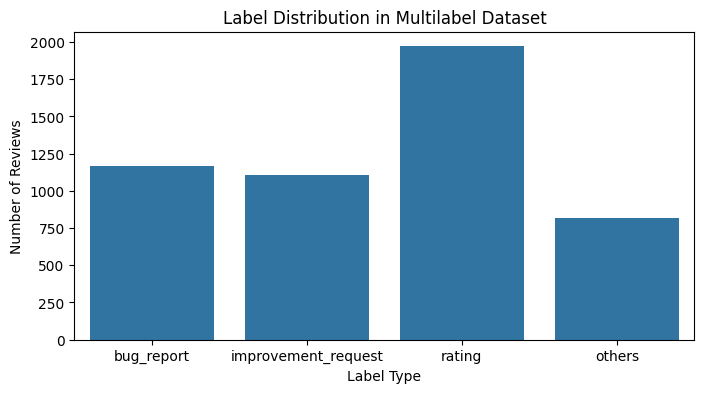

In [ ]:
# Count non-"No" values to estimate multilabel counts
class_cols = ['bug_report', 'improvement_request', 'rating', 'others']
label_counts = {}

for col in class_cols:
    label_counts[col] = (df[col] != "No").sum()

# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution in Multilabel Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Label Type")
plt.show()


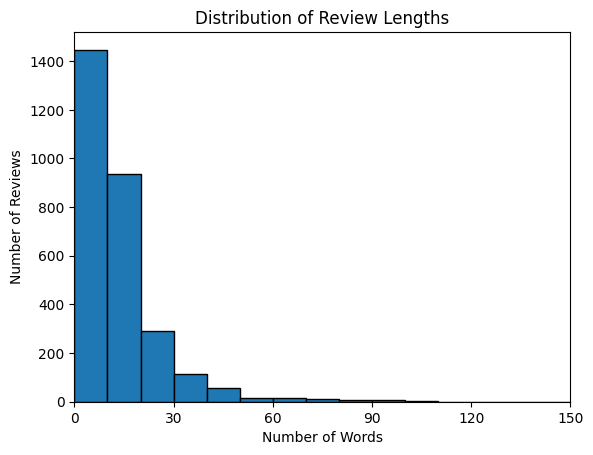


Average Review Length: 13.551724137931034


In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


plt.hist(df['review_length'], bins=range(0, 151, 10), edgecolor="black")  # Adjust bins for better granularity
plt.title("Distribution of Review Lengths")
plt.xlim(0, 150)  # Set x-axis range
plt.xticks(range(0, 151, 30))  # Adjust tick marks
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

print("\nAverage Review Length:", df['review_length'].mean())



#### B.2 Conversion to multiclass

In [ ]:
def assign_single_label(row):
    if row['bug_report'] != 'No':
        return 'bug_report'
    elif row['improvement_request'] != 'No':
        return 'improvement_request'
    elif row['rating'] != 'No':
        return 'rating'
    else:
        return 'others'

df['label'] = df.apply(assign_single_label, axis=1)
df['label'].value_counts()


,count
label,
bug_report,1164
rating,944
improvement_request,595
others,197


#### B.3 Text preprocessing

In [ ]:
def preprocess_arabic(text):
    text = str(text)
    # Normalize Arabic characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text) # kept 2 since some arabic words actually have two repeating letters

    # Remove non-Arabic letters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,يبيله تصليحات كثير,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,تبين م لي ي تم ل يب


#### B.4 Label encoding

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# For reference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'bug_report': np.int64(0), 'improvement_request': np.int64(1), 'others': np.int64(2), 'rating': np.int64(3)}


#### B.5 Data splitting

In [ ]:
# First: Train-Test Split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

# Second: Validation Split from Train (15% of train)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

# Show sizes
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 1972
Validation Samples: 348
Testing Samples: 580


#### B.6 Tokeniation and padding

In [ ]:
# Set parameters
MAX_NUM_WORDS = 10000  # top N words to keep
MAX_SEQUENCE_LENGTH = 120  # max words per review

# Tokenize
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_review'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_review'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_review'])

# Pad sequences
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
# One-hot encode labels
y_train = to_categorical(train_df['label_encoded'])
y_val = to_categorical(val_df['label_encoded'])
y_test = to_categorical(test_df['label_encoded'])

In [ ]:
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 8319


#### B.7 Building LSTM model

In [ ]:
def plot_history(histories, labels, metric='accuracy'):
    plt.figure(figsize=(8, 6))
    for history, label in zip(histories, labels):
        plt.plot(history.history[metric], label=f"{label} - train")
        plt.plot(history.history[f"val_{metric}"], linestyle='--', label=f"{label} - val")
    plt.title(f"{metric.capitalize()} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

##### B.7.1 LSTM with random embedding

In [ ]:
# Parameters
EMBEDDING_DIM_RANDOM = 100  # can be smaller
NUM_CLASSES = y_train.shape[1]

model_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),  # learn embeddings during training
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### B.7.2 LSTM with pretrained embedding

In [ ]:
# Load pretrained FastText embeddings
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

# Build embedding matrix
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_PRETRAINED))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
EMBEDDING_DIM_PRETRAINED = 300
embedding_matrix = np.load('embedding_matrix.npy')

In [ ]:
# Model 2: Use precomputed FastText vectors
model_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # freeze embeddings
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

model_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pretrained.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

#### B.8 Model training

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
# Train model 1
print("Training Model with Random Embeddings...\n")
history_random = model_random.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Training Model with Random Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 218ms/step - accuracy: 0.3478 - loss: 1.2993 - val_accuracy: 0.4023 - val_loss: 1.2493
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - accuracy: 0.4057 - loss: 1.2464 - val_accuracy: 0.4023 - val_loss: 1.2438
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.3898 - loss: 1.2543 - val_accuracy: 0.4023 - val_loss: 1.2410
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.3774 - loss: 1.2470 - val_accuracy: 0.4023 - val_loss: 1.2453
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.4065 - loss: 1.2413 - val_accuracy: 0.4023 - val_loss: 1.2413
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.3968 - loss: 1.2437 - val_accuracy: 0.4023 - val_loss: 1.2409
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.4104 - loss: 1.2321 - val_accuracy: 0.4023 - val_loss: 1.2433
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - 

In [ ]:
# Train model 2
print("Training Model with Pretrained FastText Embeddings...\n")
history_pretrained = model_pretrained.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Training Model with Pretrained FastText Embeddings...

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 241ms/step - accuracy: 0.3801 - loss: 1.3262 - val_accuracy: 0.4023 - val_loss: 1.2418
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.3895 - loss: 1.2528 - val_accuracy: 0.4023 - val_loss: 1.2419
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.3914 - loss: 1.2498 - val_accuracy: 0.3994 - val_loss: 1.2449
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.4070 - loss: 1.2314 - val_accuracy: 0.4023 - val_loss: 1.2415
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.4115 - loss: 1.2341 - val_accuracy: 0.4023 - val_loss: 1.2405
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.4016 - loss: 1.2507 - val_accuracy: 0.4023 - val_loss: 1.2469
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 0.3966 - loss: 1.2330 - val_accuracy: 0.4023 - val_loss: 1.2433
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 

In [ ]:
loss_random, accuracy_random = model_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_random:.4f}")

y_pred_probs = model_random.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("\nMulti-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Random Embeddings): 1.2397
Test Accuracy (Random Embeddings): 0.4017
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.40      1.00      0.57       233
improvement_request       0.00      0.00      0.00       119
             others       0.00      0.00      0.00        39
             rating       0.00      0.00      0.00       189

           accuracy                           0.40       580
          macro avg       0.10      0.25      0.14       580
       weighted avg       0.16      0.40      0.23       580



In [ ]:
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_pretrained:.4f}")

y_pred_probs = model_pretrained.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("\nMulti-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 1.2383
Test Accuracy (Pretrained Embeddings): 0.4017
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step

Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.40      1.00      0.57       233
improvement_request       0.00      0.00      0.00       119
             others       0.00      0.00      0.00        39
             rating       0.00      0.00      0.00       189

           accuracy                           0.40       580
          macro avg       0.10      0.25      0.14       580
       weighted avg       0.16      0.40      0.23       580



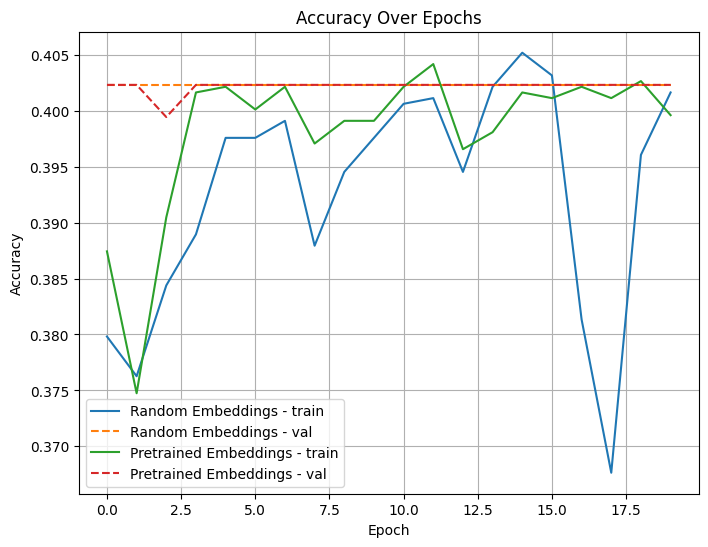

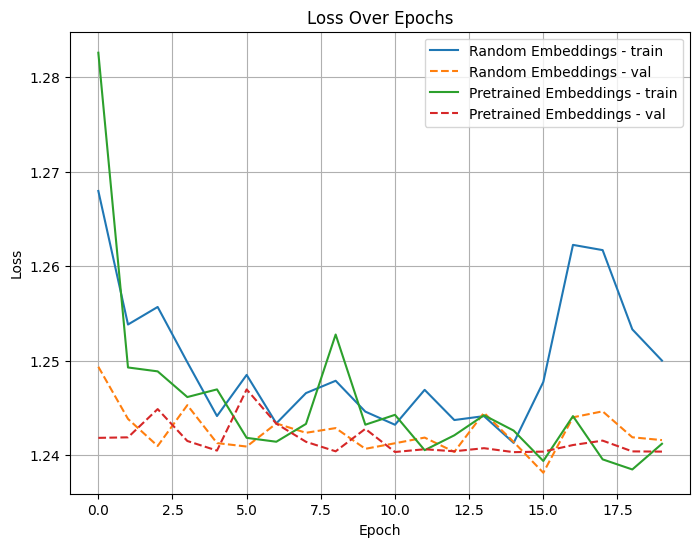

In [ ]:
plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_random, history_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

#### B.9 Classification analysis and possible improvements.

##### B.9.1 Applying oversampling

In [ ]:
# Combine features and labels
train_df_combined = train_df[['cleaned_review', 'label_encoded']]

# Separate by class
classes = train_df_combined['label_encoded'].unique()
class_dfs = [train_df_combined[train_df_combined['label_encoded'] == c] for c in classes]

# Find the class with max samples
max_len = max([len(df) for df in class_dfs])

# Oversample minority classes
resampled_dfs = [
    resample(df, replace=True, n_samples=max_len, random_state=SEED)
    if len(df) < max_len else df
    for df in class_dfs
]

# Concatenate back
balanced_train_df = pd.concat(resampled_dfs).sample(frac=1, random_state=SEED)  # shuffle

print("Balanced class counts:")
print(balanced_train_df['label_encoded'].value_counts())

Balanced class counts:
label_encoded
2    791
1    791
3    791
0    791
Name: count, dtype: int64


In [ ]:
# Tokenize balanced data
X_train_balanced_seq = tokenizer.texts_to_sequences(balanced_train_df['cleaned_review'])
X_train_balanced = pad_sequences(X_train_balanced_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Labels
y_train_balanced = to_categorical(balanced_train_df['label_encoded'])

##### B.9.2 Modifying the model to use (Oversampled data, BiLSTM, Callback functions)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

In [ ]:
EMBEDDING_DIM_RANDOM = 100
NUM_CLASSES = y_train.shape[1]

model_os_random = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_RANDOM,
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_random.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EMBEDDING_DIM_PRETRAINED = 300

model_os_pretrained = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM_PRETRAINED,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

model_os_pretrained.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_os_pretrained.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
# Train model with Random Embeddings
print("Training BiLSTM with Random Embeddings...\n")
history_os_random = model_os_random.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Random Embeddings...

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 64s 582ms/step - accuracy: 0.3375 - loss: 1.3439 - val_accuracy: 0.4799 - val_loss: 1.2076 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 63s 393ms/step - accuracy: 0.8073 - loss: 0.5381 - val_accuracy: 0.6322 - val_loss: 1.0303 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 399ms/step - accuracy: 0.9721 - loss: 0.1099 - val_accuracy: 0.5891 - val_loss: 1.4200 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9868 - loss: 0.0447
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 388ms/step - accuracy: 0.9868 - loss: 0.0447 - val_accuracy: 0.6178 - val_loss: 1.5093 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 386ms/step - accuracy: 0.9973 - loss: 0.0162 - val_accuracy: 0.6092 - val_loss: 1.7580 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring mod

In [ ]:
# Evaluate the model with random embeddings on the test data
loss_os_random, accuracy_os_random = model_os_random.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Random Embeddings): {loss_os_random:.4f}")
print(f"Test Accuracy (Random Embeddings): {accuracy_os_random:.4f}")

y_pred_probs = model_os_random.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("Multi-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))


Test Loss (Random Embeddings): 0.9621
Test Accuracy (Random Embeddings): 0.6431
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.73      0.70      0.72       233
improvement_request       0.47      0.48      0.48       119
             others       0.40      0.21      0.27        39
             rating       0.67      0.76      0.71       189

           accuracy                           0.64       580
          macro avg       0.57      0.54      0.54       580
       weighted avg       0.64      0.64      0.64       580



In [ ]:
# Train model with Pretrained FastText Embeddings
print("Training BiLSTM with Pretrained FastText Embeddings...\n")
history_os_pretrained = model_os_pretrained.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Training BiLSTM with Pretrained FastText Embeddings...

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 47s 427ms/step - accuracy: 0.3267 - loss: 1.3499 - val_accuracy: 0.3994 - val_loss: 1.2729 - learning_rate: 0.0010
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - accuracy: 0.5391 - loss: 1.1003 - val_accuracy: 0.3994 - val_loss: 1.2788 - learning_rate: 0.0010
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 410ms/step - accuracy: 0.6246 - loss: 0.9214 - val_accuracy: 0.4943 - val_loss: 1.1771 - learning_rate: 0.0010
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - accuracy: 0.6785 - loss: 0.8194 - val_accuracy: 0.4684 - val_loss: 1.2318 - learning_rate: 0.0010
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7484 - loss: 0.6620
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.7483 - loss: 0.6619 - val_accuracy: 0.5115 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 6/10
99/99 ━━━━━━━━━━━

In [ ]:
# Evaluate the model with pretrained embeddings on the test data
loss_os_pretrained, accuracy_os_pretrained = model_os_pretrained.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss_os_pretrained:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy_os_pretrained:.4f}")


y_pred_probs = model_os_pretrained.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)
label_cols = label_encoder.classes_

print("Multi-Class Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 1.0502
Test Accuracy (Pretrained Embeddings): 0.5586
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step
Multi-Class Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.74      0.55      0.63       233
improvement_request       0.40      0.55      0.46       119
             others       0.27      0.56      0.37        39
             rating       0.67      0.57      0.62       189

           accuracy                           0.56       580
          macro avg       0.52      0.56      0.52       580
       weighted avg       0.62      0.56      0.57       580



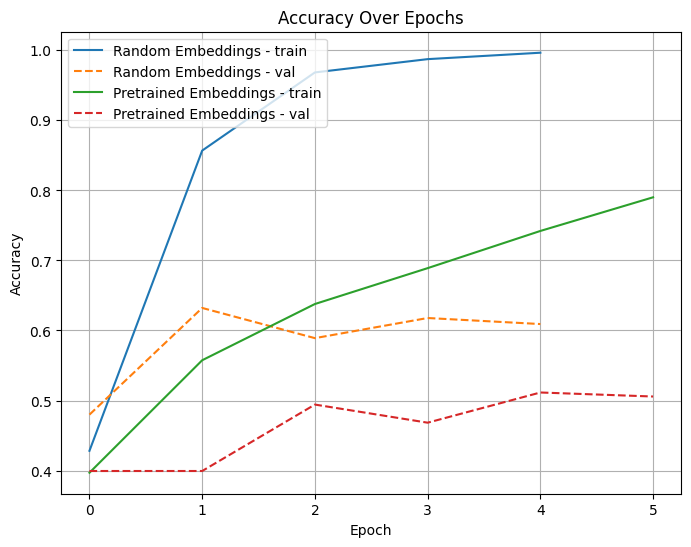

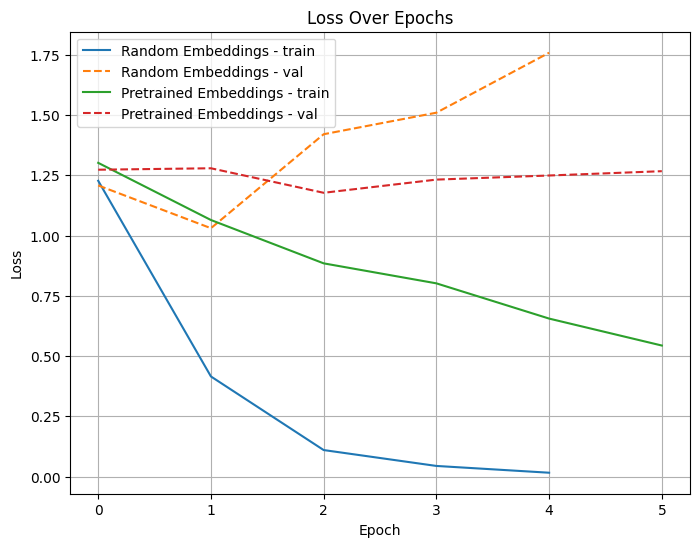

In [ ]:
plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='accuracy'
)

plot_history(
    [history_os_random, history_os_pretrained],
    ["Random Embeddings", "Pretrained Embeddings"],
    metric='loss'
)

## Part-C: Multilabel App Review Classification: from scratch

### C.1 Loading data

In [ ]:
# Load multilabel dataset
df = pd.read_csv("App Reviews-Multilabel.csv")

# Define label columns
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

#### C.2 Data statistics

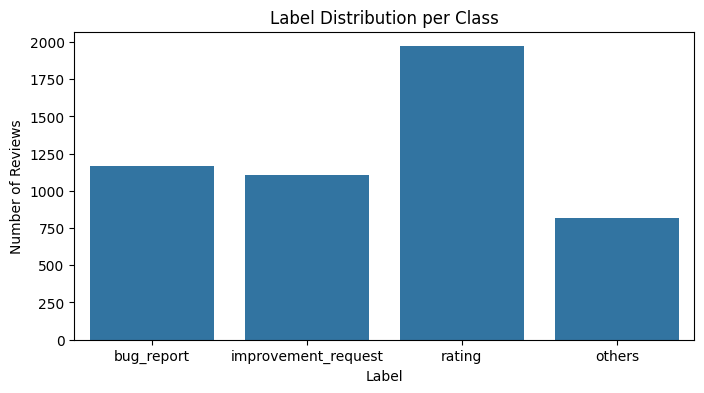


 bug_report             1164
improvement_request    1103
rating                 1971
others                  820
dtype: int64


In [ ]:
label_sums = df[label_cols].sum()

plt.figure(figsize=(8, 4))
sns.barplot(x=label_sums.index, y=label_sums.values)
plt.title("Label Distribution per Class")
plt.ylabel("Number of Reviews")
plt.xlabel("Label")
plt.show()

print("\n",label_sums)


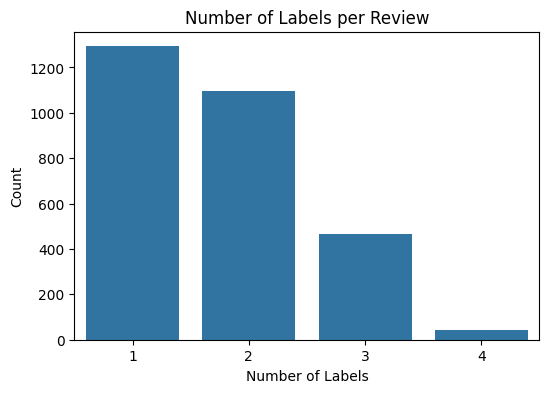

num_labels
1    1293
2    1098
3     467
4      42
Name: count, dtype: int64


In [ ]:
df['num_labels'] = df[label_cols].sum(axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(x=df['num_labels'])
plt.title("Number of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.show()

print(df['num_labels'].value_counts().sort_index())


Average review length: 13.346206896551724
Max review length: 576


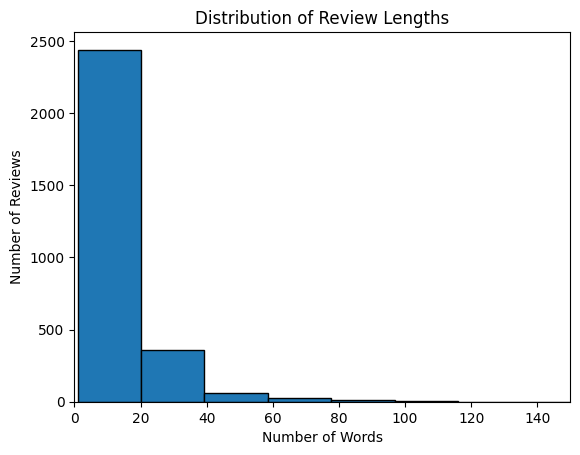

In [ ]:
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))

print("Average review length:", df['review_length'].mean())
print("Max review length:", df['review_length'].max())

plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.xlim(0, 150)
plt.show()


#### C.3 Text preprocessing

In [ ]:
def preprocess_arabic(text):
    text = str(text)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df.head()

,review,bug_report,improvement_request,rating,others,num_labels,cleaned_review
0,يبيله تصليحات كثير,1,1,1,0,3,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,3,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,2,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,1,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,0,0,1,1,2,تبين م لي ي تم ل يب


#### C.4 Data splitting

In [ ]:
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']
X_text = df['cleaned_review']
y = df[label_cols].values

# 80-20 train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=SEED)

# 15% val from train
X_train_text, X_val_text, y_train, y_val = train_test_split(X_train_text, y_train, test_size=0.15, random_state=SEED)


#### C.5 Tokenization and padding

In [ ]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 120

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=MAX_SEQUENCE_LENGTH, padding='post')

#### C.6 Building BiLSTM model

In [ ]:
embedding_index = {}
with open("cc.ar.300.vec", encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

In [ ]:
# Build embedding matrix
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
EMBEDDING_DIM = 300
np.save('embedding_matrix.npy', embedding_matrix)


In [ ]:
NUM_CLASSES = len(label_cols)

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS,
              output_dim=EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='sigmoid')  # multilabel output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 463ms/step - accuracy: 0.3314 - loss: 0.6529 - val_accuracy: 0.4282 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 475ms/step - accuracy: 0.4559 - loss: 0.5538 - val_accuracy: 0.5029 - val_loss: 0.5096 - learning_rate: 0.0010
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 414ms/step - accuracy: 0.5671 - loss: 0.4741 - val_accuracy: 0.5546 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 446ms/step - accuracy: 0.5790 - loss: 0.4611 - val_accuracy: 0.5374 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.5854 - loss: 0.4227 - val_accuracy: 0.5718 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.6289 - loss: 0.4026 - val_accuracy: 0.5661 - val_loss: 0.4617 - learning_rate: 0.0010
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step - accuracy: 0.6167 - loss: 0.

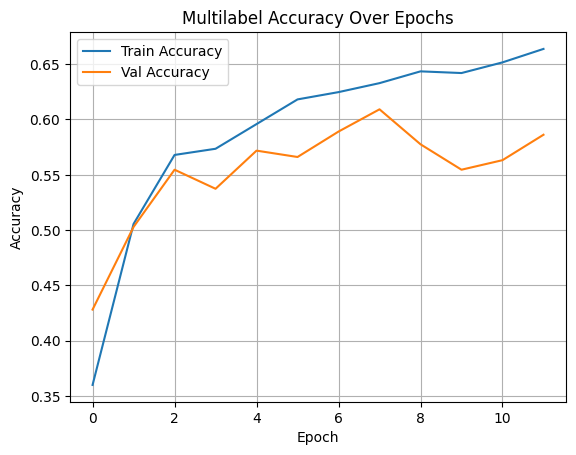

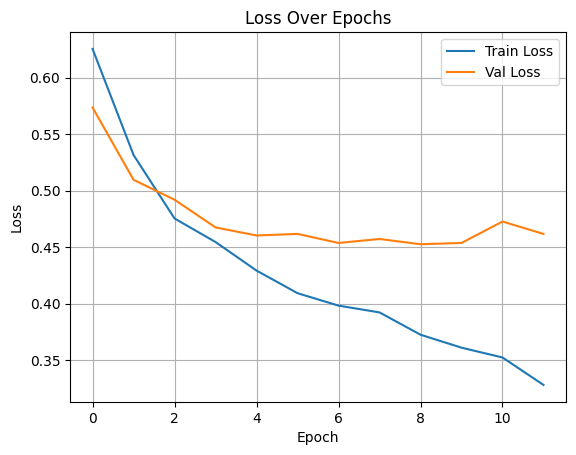

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Multilabel Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### C.7 Model evaluation

In [ ]:
# Evaluate the model with pretrained embeddings on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (Pretrained Embeddings): {loss:.4f}")
print(f"Test Accuracy (Pretrained Embeddings): {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)  # thresholding

print("Multilabel Classification Report:\n")
print(classification_report(y_test, y_pred_binary, target_names=label_cols, zero_division=0))

Test Loss (Pretrained Embeddings): 0.4654
Test Accuracy (Pretrained Embeddings): 0.5534
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step
Multilabel Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.77      0.77      0.77       239
improvement_request       0.70      0.63      0.66       238
             rating       0.88      0.78      0.82       384
             others       0.65      0.54      0.59       159

          micro avg       0.78      0.70      0.74      1020
          macro avg       0.75      0.68      0.71      1020
       weighted avg       0.78      0.70      0.74      1020
        samples avg       0.81      0.75      0.74      1020



## Part-D: Multiclass App Review Classification: Finetune an MLM

### Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler


### Set seed

In [ ]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

### Loading data

In [ ]:
# Load dataset
df = pd.read_csv("AppReview-Multilabel.csv")
df.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High


In [ ]:
print(df.describe())

              review bug_report improvement_request rating others
count           2900       2900                2900   2900   2900
unique          2892          4                   4      4      4
top     اكثر من رائع         No                  No   High     No
freq               3       1736                1797    988   2080


### Label distribution

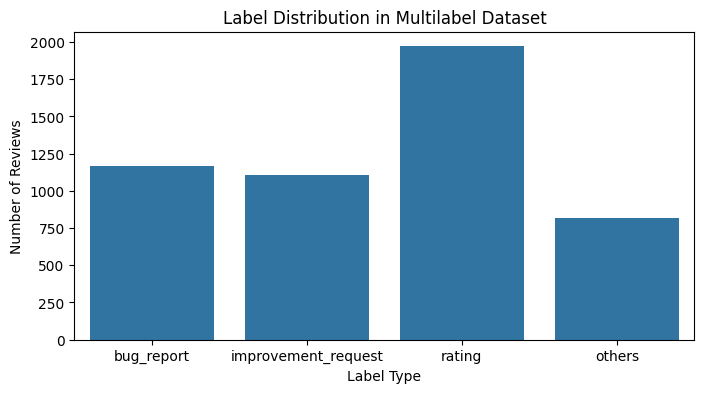

In [ ]:
# Count non-"No" values to estimate multilabel counts
class_cols = ['bug_report', 'improvement_request', 'rating', 'others']
label_counts = {}

for col in class_cols:
    label_counts[col] = (df[col] != "No").sum()

# Plot label distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Label Distribution in Multilabel Dataset")
plt.ylabel("Number of Reviews")
plt.xlabel("Label Type")
plt.show()


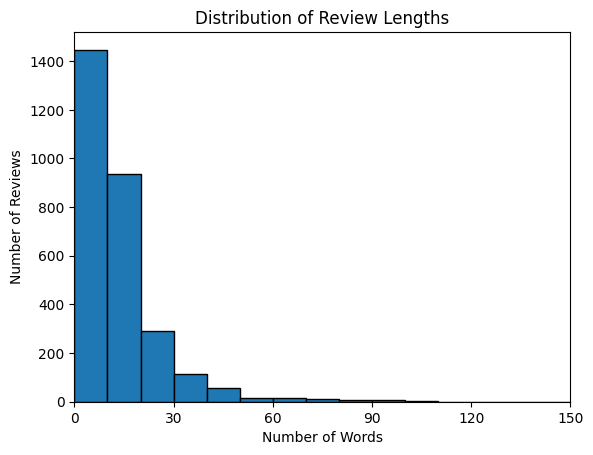


Average Review Length: 13.551724137931034

Max Review Length: 576


In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))


plt.hist(df['review_length'], bins=range(0, 151, 10), edgecolor="black")  # Adjust bins for better granularity
plt.title("Distribution of Review Lengths")
plt.xlim(0, 150)  # Set x-axis range
plt.xticks(range(0, 151, 30))  # Adjust tick marks
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

print("\nAverage Review Length:", df['review_length'].mean())

print("\nMax Review Length:", df['review_length'].max())


### Conversion to multiclass

In [ ]:
def assign_single_label(row):
    if row['bug_report'] != 'No':
        return 'bug_report'
    elif row['improvement_request'] != 'No':
        return 'improvement_request'
    elif row['rating'] != 'No':
        return 'rating'
    else:
        return 'others'

df['label'] = df.apply(assign_single_label, axis=1)
df['label'].value_counts()


,count
label,
bug_report,1164
rating,944
improvement_request,595
others,197


### Text preprocessing

In [ ]:
def preprocess_arabic(text):
    text = str(text)
    # Normalize Arabic characters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    # Remove diacritics
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Remove repeated characters
    text = re.sub(r'(.)\1+', r'\1\1', text) # kept 2 since some arabic words actually have two repeating letters

    # Remove non-Arabic letters and digits
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,يبيله تصليحات كثير,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,تبين م لي ي تم ل يب


### Label encoding

In [ ]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# For reference
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'bug_report': np.int64(0), 'improvement_request': np.int64(1), 'others': np.int64(2), 'rating': np.int64(3)}


### Data splitting

In [ ]:
# First: Train-Test Split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

# Second: Validation Split from Train (15% of train)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

# Show sizes
print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Testing Samples: {len(test_df)}")

Training Samples: 1972
Validation Samples: 348
Testing Samples: 580


### Configuration

In [ ]:
# Configuration
MODEL_NAME = "UBC-NLP/MARBERT"
MAX_LENGTH = df['cleaned_review'].apply(lambda x: len(str(x).split())).max()
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EPOCHS = 25
NUM_CLASSES = len(np.unique(train_df['label_encoded']))


### Tokenizer

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = TFAutoModel.from_pretrained(MODEL_NAME)

# Tokenize data
def tokenize_data(texts, labels=None, max_length=MAX_LENGTH):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

    inputs = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }

    if labels is not None:
        return inputs, labels
    return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/652M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at UBC-NLP/MARBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### One-hot encoding

In [ ]:
# One-hot encode labels
y_train = to_categorical(train_df['label_encoded'])
y_val = to_categorical(val_df['label_encoded'])
y_test = to_categorical(test_df['label_encoded'])

### Prepare dataset

In [ ]:
# Create TF datasets
train_encodings, train_labels = tokenize_data(train_df['cleaned_review'], y_train)
val_encodings, val_labels = tokenize_data(val_df['cleaned_review'], y_val)
test_encodings, test_labels = tokenize_data(test_df['cleaned_review'], y_test)

# Convert to TF Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_encodings, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_encodings, test_labels))

# Prepare batched datasets with shuffling
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Build the model

In [ ]:
# Build the model
def build_model(base_model, num_classes):
    class BertClassifier(tf.keras.Model):
        def __init__(self, base_model, num_classes):
            super(BertClassifier, self).__init__()
            self.base_model = base_model
            self.dropout = layers.Dropout(0.1)
            self.classifier = layers.Dense(num_classes, activation='softmax')

        def call(self, inputs, training=False):
            outputs = self.base_model(inputs)  # Pass the inputs
            pooled_output = outputs.last_hidden_state[:, 0, :]
            dropout_output = self.dropout(pooled_output, training=training)
            return self.classifier(dropout_output)

    model = BertClassifier(base_model, num_classes)

    # Freeze base model layers for initial training
    model.base_model.trainable = False

    return model

# Create model
model = build_model(base_model, NUM_CLASSES)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Model summary
model.summary()

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train initial model with frozen layers
print("Training with frozen BERT layers...")
history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks
)

# Unfreeze the last few layers of the base model for fine-tuning
print("Fine-tuning with unfrozen layers...")
base_model.trainable = True

# Keep the first 75% of layers frozen, fine-tune the last 25%
trainable_layers = int(len(base_model.layers) * 0.25)
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss=loss,
    metrics=['accuracy']
)

# Train model with unfrozen layers
history_finetuning = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Training with frozen BERT layers...
Epoch 1/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.4915 - loss: 1.1756 - val_accuracy: 0.6121 - val_loss: 0.9334 - learning_rate: 0.0010
Epoch 2/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6360 - loss: 0.8988 - val_accuracy: 0.6437 - val_loss: 0.8524 - learning_rate: 0.0010
Epoch 3/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6640 - loss: 0.8358 - val_accuracy: 0.6667 - val_loss: 0.8097 - learning_rate: 0.0010
Fine-tuning with unfrozen layers...
Epoch 1/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step - accuracy: 0.6906 - loss: 0.7523 - val_accuracy: 0.7126 - val_loss: 0.7860 - learning_rate: 1.0000e-04
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7142 - loss: 0.7506 - val_accuracy: 0.7011 - val_loss: 0.7824 - learning_rate: 1.0000e-04
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7034 - loss: 0.7697 - val_accuracy: 0.7011 - val_loss: 0.7786 - learning_rate: 1.0000e-

### Model Evaluation

37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step
Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.78      0.83      0.80       233
improvement_request       0.64      0.50      0.56       119
             others       0.50      0.18      0.26        39
             rating       0.72      0.86      0.78       189

           accuracy                           0.73       580
          macro avg       0.66      0.59      0.60       580
       weighted avg       0.71      0.73      0.71       580



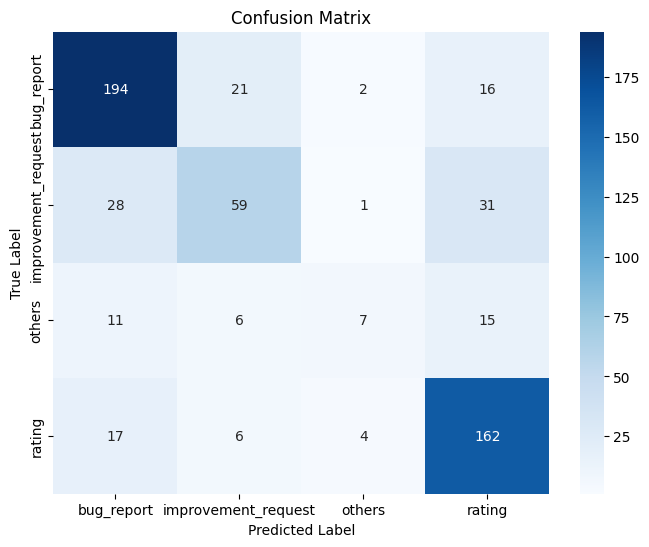

In [ ]:
# Get Predictions:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Classification Report:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys(), zero_division=0))

# Confusion Matrix:
cm = confusion_matrix(y_true, y_pred)

# Plotting the Confusion Matrix:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

According to the results the model kept learning so increasing the epochs could help, also the "other" class has low results because of class imbalance.

### Training with oversampling

In [ ]:

# Create TF datasets
train_encodings, train_labels = tokenize_data(train_df['cleaned_review'], y_train)
val_encodings, val_labels = tokenize_data(val_df['cleaned_review'], y_val)
test_encodings, test_labels = tokenize_data(test_df['cleaned_review'], y_test)

# Apply RandomOverSampler before creating TF datasets
ros = RandomOverSampler(random_state=42)
train_encodings_resampled_input_ids, y_train_resampled = ros.fit_resample(train_encodings['input_ids'], y_train)
train_encodings_resampled_attention_mask, _ = ros.fit_resample(train_encodings['attention_mask'], y_train)

# Updated train_encodings
train_encodings_resampled = {
    'input_ids': train_encodings_resampled_input_ids,
    'attention_mask': train_encodings_resampled_attention_mask
}

# Convert to TF Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings_resampled, y_train_resampled))
val_dataset = tf.data.Dataset.from_tensor_slices((val_encodings, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_encodings, test_labels))

# Prepare batched datasets with shuffling
train_dataset = train_dataset.shuffle(len(train_encodings_resampled['input_ids'])).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create model
model = build_model(base_model, NUM_CLASSES)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Model summary
model.summary()

Model: "bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
LEARNING_RATE = 1e-3

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train initial model with frozen layers
print("Training with frozen BERT layers...")
history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks
)

# Unfreeze the last few layers of the base model for fine-tuning
print("Fine-tuning with unfrozen layers...")
base_model.trainable = True

# Keep the first 75% of layers frozen, fine-tune the last 25%
trainable_layers = int(len(base_model.layers) * 0.25)
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss=loss,
    metrics=['accuracy']
)

# Train model with unfrozen layers
history_finetuning = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)


Training with frozen BERT layers...
Epoch 1/3
198/198 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.4654 - loss: 1.2339 - val_accuracy: 0.6408 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 2/3
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6788 - loss: 0.8997 - val_accuracy: 0.7040 - val_loss: 0.8263 - learning_rate: 0.0010
Epoch 3/3
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7156 - loss: 0.7842 - val_accuracy: 0.6839 - val_loss: 0.8281 - learning_rate: 0.0010
Fine-tuning with unfrozen layers...
Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.7284 - loss: 0.7731 - val_accuracy: 0.6925 - val_loss: 0.8416 - learning_rate: 1.0000e-04
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7237 - loss: 0.7905 - val_accuracy: 0.7069 - val_loss: 0.8275 - learning_rate: 1.0000e-04
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.7082 - loss: 0.7903 - val_accuracy: 0.7011 - val_loss: 0.8282 - learning_rate: 1.0000e-

37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step
Classification Report:
                     precision    recall  f1-score   support

         bug_report       0.86      0.74      0.80       233
improvement_request       0.58      0.66      0.62       119
             others       0.34      0.69      0.45        39
             rating       0.81      0.69      0.74       189

           accuracy                           0.71       580
          macro avg       0.64      0.70      0.65       580
       weighted avg       0.75      0.71      0.72       580



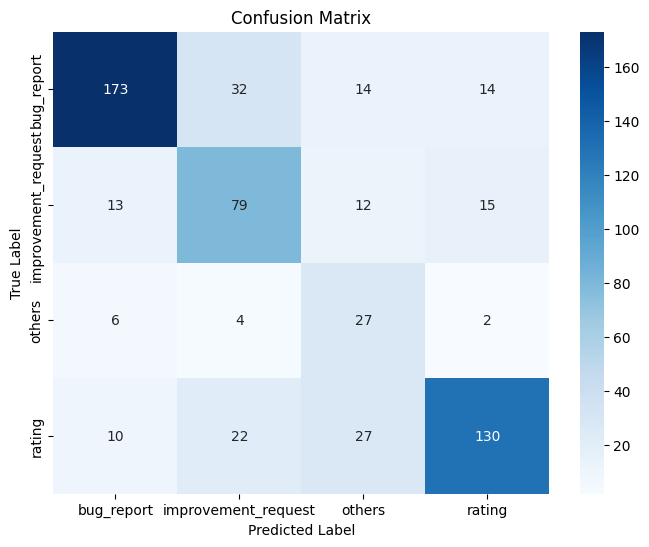

In [ ]:
# Get Predictions:
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get True Labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Classification Report:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys(), zero_division=0))

# Confusion Matrix:
cm = confusion_matrix(y_true, y_pred)

# Plotting the Confusion Matrix:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The results for "others" class became better however still not as good as other classes due to imbalance.

possible improvments: a more complicated and efficient way to address class imbalance, and maybe lower learning rate with more epochs for optimal performance

## Part-E: Multilabel App Review Classification: Finetune an MLM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

#### Loading data

In [ ]:
# Load multilabel dataset
df = pd.read_csv("App Reviews-Multilabel.csv")

# Define label columns
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

#### Data statistics

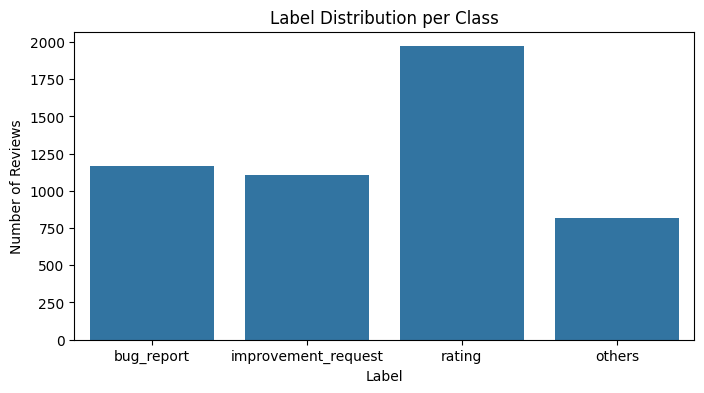


 bug_report             1164
improvement_request    1103
rating                 1971
others                  820
dtype: int64


In [ ]:
label_sums = df[label_cols].sum()

plt.figure(figsize=(8, 4))
sns.barplot(x=label_sums.index, y=label_sums.values)
plt.title("Label Distribution per Class")
plt.ylabel("Number of Reviews")
plt.xlabel("Label")
plt.show()

print("\n",label_sums)


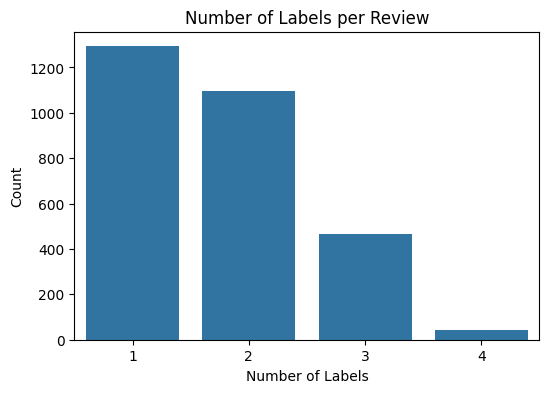

num_labels
1    1293
2    1098
3     467
4      42
Name: count, dtype: int64


In [ ]:
df['num_labels'] = df[label_cols].sum(axis=1)

plt.figure(figsize=(6, 4))
sns.countplot(x=df['num_labels'])
plt.title("Number of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Count")
plt.show()

print(df['num_labels'].value_counts().sort_index())


Average review length: 13.551724137931034
Max review length: 576


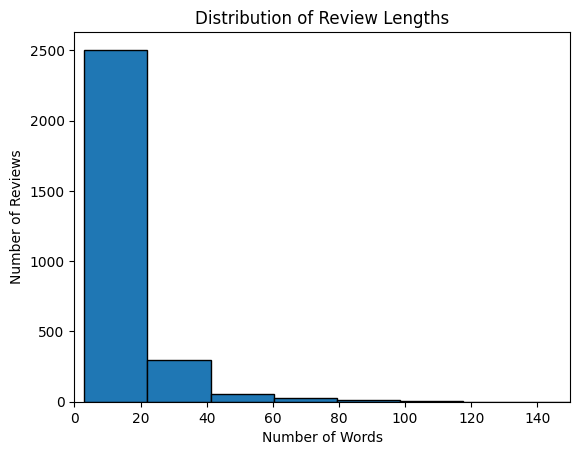

In [ ]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

print("Average review length:", df['review_length'].mean())
print("Max review length:", df['review_length'].max())

plt.hist(df['review_length'], bins=30, edgecolor='black')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.xlim(0, 150)
plt.show()


#### Text preprocessing

In [ ]:
def preprocess_arabic(text):
    text = str(text)
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(preprocess_arabic)
df.head()

,review,bug_report,improvement_request,rating,others,num_labels,review_length,cleaned_review
0,يبيله تصليحات كثير,1,1,1,0,3,3,يبيله تصليحات كثير
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1,3,6,ماتحملت ابددا ونا دفعت فلوس
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0,2,13,اتمني منكم عمل خيار لتفضيل المسلسل بالكامل عوض...
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,1,8,ممتاز وبسيط وتشغيله لا يوثر علي سرعه الانترنت
4,تبين م لي ي تم ل يب,0,0,1,1,2,7,تبين م لي ي تم ل يب


#### Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Define label columns
label_cols = ['bug_report', 'improvement_request', 'rating', 'others']

# 80-20 train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 15% validation split from train
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)


In [ ]:
y_train = train_df[label_cols].values
y_val = val_df[label_cols].values
y_test = test_df[label_cols].values


### Configuration

In [ ]:
# Configuration
MODEL_NAME = "UBC-NLP/MARBERT"
MAX_LENGTH = 1024
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EPOCHS = 25
NUM_CLASSES = len(label_cols)


### Tokenizer

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = TFAutoModel.from_pretrained(MODEL_NAME)

# Tokenize data
def tokenize_data(texts, labels=None, max_length=MAX_LENGTH):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )

    inputs = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }

    if labels is not None:
        return inputs, labels
    return inputs

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/652M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at UBC-NLP/MARBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Prepare dataset

In [ ]:
# Create TF datasets
train_encodings, train_labels = tokenize_data(train_df['cleaned_review'], y_train)
val_encodings, val_labels = tokenize_data(val_df['cleaned_review'], y_val)
test_encodings, test_labels = tokenize_data(test_df['cleaned_review'], y_test)

# Convert to TF Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_encodings, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_encodings, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_encodings, test_labels))

# Prepare batched datasets with shuffling
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Build the model

In [ ]:
# Build the model for multilabel classification
def build_model(base_model, num_classes):
    class BertMultilabelClassifier(tf.keras.Model):
        def __init__(self, base_model, num_classes):
            super(BertMultilabelClassifier, self).__init__()
            self.base_model = base_model
            self.dropout = layers.Dropout(0.1)

            self.classifier = layers.Dense(num_classes, activation='sigmoid')

        def call(self, inputs, training=False):
            outputs = self.base_model(inputs)
            pooled_output = outputs.last_hidden_state[:, 0, :]
            dropout_output = self.dropout(pooled_output, training=training)
            return self.classifier(dropout_output)

    model = BertMultilabelClassifier(base_model, num_classes)

    # Freeze base model layers for initial training
    model.base_model.trainable = False

    return model

# Create model
model = build_model(base_model, NUM_CLASSES)

# Compile the model with binary crossentropy and binary accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Model summary
model.summary()

Model: "bert_multilabel_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train initial model with frozen layers
print("Training with frozen BERT layers...")
history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks
)

# Unfreeze the last few layers of the base model for fine-tuning
print("Fine-tuning with unfrozen layers...")
base_model.trainable = True

# Keep the first 75% of layers frozen, fine-tune the last 25%
trainable_layers = int(len(base_model.layers) * 0.25)
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/5),
    loss=loss,
    metrics=metrics
)

# Train model with unfrozen layers
history_finetuning = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Training with frozen BERT layers...
Epoch 1/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.6419 - loss: 0.6362 - val_accuracy: 0.7155 - val_loss: 0.5557 - learning_rate: 0.0010
Epoch 2/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7381 - loss: 0.5270 - val_accuracy: 0.7392 - val_loss: 0.5150 - learning_rate: 0.0010
Epoch 3/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7755 - loss: 0.4837 - val_accuracy: 0.7593 - val_loss: 0.4877 - learning_rate: 0.0010
Fine-tuning with unfrozen layers...
Epoch 1/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.7750 - loss: 0.4625 - val_accuracy: 0.7615 - val_loss: 0.4834 - learning_rate: 2.0000e-04
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7833 - loss: 0.4581 - val_accuracy: 0.7658 - val_loss: 0.4796 - learning_rate: 2.0000e-04
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.7958 - loss: 0.4494 - val_accuracy: 0.7665 - val_loss: 0.4765 - learning_rate: 

### Model evaluation

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)  # thresholding

print("Multilabel Classification Report:\n")
print(classification_report(y_test, y_pred_binary, target_names=label_cols, zero_division=0))

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step
Multilabel Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.87      0.67      0.76       251
improvement_request       0.71      0.55      0.62       229
             rating       0.81      0.91      0.85       379
             others       0.76      0.42      0.54       166

          micro avg       0.80      0.69      0.74      1025
          macro avg       0.79      0.64      0.69      1025
       weighted avg       0.79      0.69      0.73      1025
        samples avg       0.81      0.74      0.74      1025



The results are somehow good, however "rating" gets best f1-score due to having more samples than the other classes, so class imbalance must be addressed, also in the training the model seem to be able to train much more than 25 epochs

### Training with class weights and more epochs

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate weights for each label column
label_weights = {}
for label_col in label_cols:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df[label_col]),
        y=train_df[label_col]
    )
    label_weights[label_col] = dict(enumerate(class_weights))  # Store as dictionary


import tensorflow as tf

def weighted_binary_crossentropy(y_true, y_pred):

    loss = 0.0
    for i, label_col in enumerate(label_cols):
        weights = tf.gather(tf.constant(list(label_weights[label_col].values())), tf.cast(y_true[:, i], tf.int32))
        loss += tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true[:, i], y_pred[:, i]) * weights)
    return loss / len(label_cols)  # Average loss over all labels


In [ ]:
from sklearn.utils.class_weight import compute_class_weight


# Create model
model = build_model(base_model, NUM_CLASSES)

# Compile the model with binary crossentropy and binary accuracy
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = weighted_binary_crossentropy
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Model summary
model.summary()


# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Train initial model with frozen layers
print("Training with frozen BERT layers...")
history_frozen = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=callbacks,
)

# Unfreeze the last few layers of the base model for fine-tuning
print("Fine-tuning with unfrozen layers...")
base_model.trainable = True

# Keep the first 75% of layers frozen, fine-tune the last 25%
trainable_layers = int(len(base_model.layers) * 0.25)
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/5),
    loss=loss,
    metrics=metrics
)

# Train model with unfrozen layers
history_finetuning = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks,
)

Model: "bert_multilabel_classifier_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training with frozen BERT layers...
Epoch 1/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.6262 - loss: 0.6594 - val_accuracy: 0.7069 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7446 - loss: 0.5263 - val_accuracy: 0.7601 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 3/3
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7836 - loss: 0.4789 - val_accuracy: 0.7687 - val_loss: 0.5015 - learning_rate: 0.0010
Fine-tuning with unfrozen layers...
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.7832 - loss: 0.4634 - val_accuracy: 0.7672 - val_loss: 0.4968 - learning_rate: 2.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7869 - loss: 0.4664 - val_accuracy: 0.7680 - val_loss: 0.4931 - learning_rate: 2.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7897 - loss: 0.4611 - val_accuracy: 0.7694 - val_loss: 0.4907 - learning_rate: 

In [ ]:
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs >= 0.5).astype(int)  # thresholding

print("Multilabel Classification Report:\n")
print(classification_report(y_test, y_pred_binary, target_names=label_cols, zero_division=0))

37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step
Multilabel Classification Report:

                     precision    recall  f1-score   support

         bug_report       0.86      0.67      0.75       251
improvement_request       0.73      0.57      0.64       229
             rating       0.83      0.88      0.85       379
             others       0.74      0.52      0.61       166

          micro avg       0.80      0.70      0.75      1025
          macro avg       0.79      0.66      0.71      1025
       weighted avg       0.80      0.70      0.74      1025
        samples avg       0.83      0.75      0.75      1025



applying class weights seems to be giving better results for minority classes.

areas of improvments:

balancing the data in a more efficient way, also more importantly the model seems to be able to achieve better results by training with way more epochs using learning rate scheduler, 100 epochs might do the trick.

## Part-F: Multiclass App Review Classification: In-Context learning using causal LLM


#### F.1 Zero-shot learning

##### F.1.1 LLM API setup

In [ ]:
# Set up OpenAI client with OpenRouter
openai.api_key = secret.get_openai_key()
client = openai.OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=openai.api_key,
)

##### F.1.2 Data Loading and Splitting

In [ ]:
# Load and prepare the dataset
def load_data(file_path="App Reviews-SingleLabel-Multiclass.csv"):
    """
    Load the app review dataset and split it into train, validation, and test sets.

    Args:
        file_path: Path to the CSV file

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and testing
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)

    # Check if data is loaded correctly
    print(f"Dataset shape: {df.shape}")
    display(df.head())

    # Check class distribution
    print("\nClass distribution:")
    class_dist = df['Label'].value_counts(normalize=True)
    print(class_dist)

    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['Label'])

    # First: Train-Test Split (80-20)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label_encoded'])

    # Second: Validation Split from Train (15% of train)
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['label_encoded'])

    print(f"\nTrain set: {train_df.shape[0]} samples")
    print(f"Validation set: {val_df.shape[0]} samples")
    print(f"Test set: {test_df.shape[0]} samples")

    return train_df, val_df, test_df

##### F.1.3 Class Distribution

In [ ]:
# Calculate class distribution from training data
def get_class_distribution(train_df):
    """
    Calculate class distribution from training data.

    Args:
        train_df: Training DataFrame

    Returns:
        class_dist: Dictionary with class distribution information
    """
    class_counts = train_df['Label'].value_counts()
    total = class_counts.sum()
    class_dist = {label: f"{count} ({count/total:.1%})" for label, count in class_counts.items()}
    return class_dist

##### F.1.4 LLM API Call

In [ ]:
# Function to call the LLM API with retry mechanism
def call_llm_api(messages, model="openai/gpt-3.5-turbo", temperature=0, max_retries=3, delay=2):
    """
    Call the LLM API with retry mechanism.

    Args:
        messages: List of message dictionaries
        model: LLM model to use
        temperature: Temperature parameter for generation
        max_retries: Maximum number of retries
        delay: Delay between retries

    Returns:
        response_text: Text response from the LLM
    """
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
            )
            if response and response.choices:
                content = response.choices[0].message.content
                if content is not None:
                    return content.strip()
            return "Error: Empty response"
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Attempt {attempt + 1} failed: {str(e)}. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                return f"Error after {max_retries} attempts: {str(e)}"


##### F.1.5 Response Formatting

In [ ]:
# Parse LLM response to extract the predicted label
def parse_response(response, possible_labels):
    """
    Parse LLM response to extract the predicted label.

    Args:
        response: Raw response from the LLM
        possible_labels: List of possible class labels

    Returns:
        predicted_label: Extracted label from the response
    """
    response = response.lower()

    # Try to find JSON format
    json_pattern = r'\{.*\}'
    json_match = re.search(json_pattern, response, re.DOTALL)
    if json_match:
        try:
            json_data = json.loads(json_match.group())
            if 'label' in json_data:
                return json_data['label']
        except:
            pass

    # Direct search for labels
    for label in possible_labels:
        if label.lower() in response:
            return label

    # Check for specific keywords associated with each label
    if 'bug' in response or 'error' in response or 'crash' in response or 'not working' in response:
        return 'bug_report'
    elif 'improve' in response or 'request' in response or 'feature' in response or 'suggestion' in response:
        return 'improvement_request'
    elif 'star' in response or 'rate' in response or 'good' in response or 'great' in response or 'bad' in response:
        return 'rating'

    # Default to the most frequent class if nothing matches
    return 'others'

In [ ]:
# Load and prepare data
train_df, val_df, test_df = load_data()

# Define possible labels
possible_labels = ["bug_report", "rating", "improvement_request", "others"]

Loading data from App Reviews-SingleLabel-Multiclass.csv...
Dataset shape: (2900, 2)


,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others



Class distribution:
Label
rating                 0.447586
bug_report             0.260690
improvement_request    0.152414
others                 0.139310
Name: proportion, dtype: float64

Train set: 1972 samples
Validation set: 348 samples
Test set: 580 samples


##### F.1.6 Prompt Design(English, Arabic)

In [ ]:
def get_zero_shot_prompts_english():
    """
    Define different prompt templates for zero-shot learning in English.

    Returns:
        prompts_dict: Dictionary of prompts
    """
    prompts = {
        "basic": """
You are an expert in classifying app reviews. Given the following app review, classify it into one of these categories:
- bug_report: Reports of bugs or technical issues in the app
- improvement_request: Suggestions for new features or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction
- others: Reviews that don't fall into any of the above categories

App Review: "{review}"

Return only the category label.
""",

        "detailed": """
You are an expert in classifying app reviews. Given the following app review, classify it into one of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Analyze the review carefully for mentions of technical problems, suggestions for improvements, or expressions of satisfaction/dissatisfaction.

App Review: "{review}"

Provide your classification in this format:
{{
  "label": "category_name"
}}
""",

        "cot": """
You are an expert in classifying app reviews. Given the following app review, classify it into one of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Think step by step:
1. What is the main point of this review?
2. Does it mention any bugs, errors or technical issues?
3. Does it suggest new features or improvements?
4. Does it express satisfaction or dissatisfaction with the app?
5. Based on your analysis, what category best fits this review?

App Review: "{review}"

Provide your classification in this format:
{{
  "label": "category_name"
}}
""",

        "example_based": """
You are an expert in classifying app reviews. Given the following app review, classify it into one of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Here are some examples of each category:
- bug_report: "The app keeps crashing when I try to upload photos." or "Cannot login, it shows error message."
- improvement_request: "Please add dark mode" or "It would be nice if we could customize the interface."
- rating: "Great app, love it!" or "This app is terrible, don't waste your time."
- others: "Does this work on iPad?" or "What's your privacy policy?"

App Review: "{review}"

Provide your classification in this format:
{{
  "label": "category_name"
}}
""",
    }

    return prompts

In [ ]:
# Define different prompts for zero-shot learning in Arabic
def get_zero_shot_prompts_arabic():
    """
    Define different prompt templates for zero-shot learning in Arabic.

    Returns:
        prompts_dict: Dictionary of prompts
    """
    prompts = {
        "basic": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى إحدى هذه الفئات:
- bug_report: تقارير عن أخطاء أو مشاكل تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

مراجعة التطبيق: "{review}"

أعد فقط تسمية الفئة.
""",

        "detailed": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى إحدى هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

حلل المراجعة بعناية بحثاً عن ذكر المشاكل التقنية، اقتراحات للتحسينات، أو تعبيرات عن الرضا/عدم الرضا.

مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "label": "اسم_الفئة"
}}
""",

        "cot": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى إحدى هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

فكر خطوة بخطوة:
1. ما هي النقطة الرئيسية لهذه المراجعة؟
2. هل تذكر أي أخطاء، مشاكل أو قضايا تقنية؟
3. هل تقترح ميزات جديدة أو تحسينات؟
4. هل تعبر عن الرضا أو عدم الرضا مع التطبيق؟
5. بناءً على تحليلك، ما هي الفئة التي تناسب هذه المراجعة بشكل أفضل؟

مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "label": "اسم_الفئة"
}}
""",

        "example_based": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى إحدى هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

إليك بعض الأمثلة لكل فئة:
- bug_report: "التطبيق يتوقف عندما أحاول تحميل الصور." أو "لا يمكنني تسجيل الدخول، تظهر رسالة خطأ."
- improvement_request: "الرجاء إضافة الوضع المظلم" أو "سيكون من الجيد لو استطعنا تخصيص الواجهة."
- rating: "تطبيق رائع، أحبه!" أو "هذا التطبيق فظيع، لا تضيع وقتك."
- others: "هل يعمل هذا على iPad؟" أو "ما هي سياسة الخصوصية الخاصة بك؟"

مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "label": "اسم_الفئة"
}}
""",
    }

    return prompts

##### F.1.7 Adding Class Distribution to the LLM Prompt(Bonus)

In [ ]:
# Function to create a prompt with class distribution information
def add_class_distribution_to_prompt(prompt_template, class_dist):
    """
    Add class distribution information to a prompt.

    Args:
        prompt_template: Base prompt template
        class_dist: Dictionary with class distribution information

    Returns:
        modified_prompt: Prompt with class distribution
    """
    dist_text = "Based on our training data, the distribution of classes is as follows:\n"
    for label, percentage in class_dist.items():
        dist_text += f"- {label}: {percentage}\n"

    # Insert the distribution information before the review
    if "App Review:" in prompt_template:
        modified_prompt = prompt_template.replace("App Review:", dist_text + "\nApp Review:")
    elif "مراجعة التطبيق:" in prompt_template:
        modified_prompt = prompt_template.replace("مراجعة التطبيق:", dist_text + "\nمراجعة التطبيق:")
    else:
        modified_prompt = prompt_template + "\n" + dist_text

    return modified_prompt

##### F.1.8 Prompt Execution and Evaluation

In [ ]:
# Evaluate a prompt on validation data
def evaluate_zero_shot_prompt(prompt_template, val_df, possible_labels, language="English", include_class_dist=False, class_dist=None, n_samples=100):
    """
    Evaluate a zero-shot prompt on validation data.

    Args:
        prompt_template: Prompt template to evaluate
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        language: Language of the prompt
        include_class_dist: Whether to include class distribution
        class_dist: Dictionary with class distribution information
        n_samples: Number of samples to evaluate on

    Returns:
        accuracy: Classification accuracy
        report: Classification report
        predictions: List of predictions
    """
    # Sample from validation set
    if n_samples < len(val_df):
        sampled_df = val_df.sample(n=n_samples, random_state=42)
    else:
        sampled_df = val_df

    true_labels = sampled_df['Label'].tolist()
    predictions = []

    # If class distribution should be included
    if include_class_dist and class_dist:
        modified_prompt = add_class_distribution_to_prompt(prompt_template, class_dist)
    else:
        modified_prompt = prompt_template

    # Run inference
    for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc=f"Evaluating {language} prompt"):
        review = row['review']
        prompt = modified_prompt.format(review=review)

        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]

        response = call_llm_api(messages)
        predicted_label = parse_response(response, possible_labels)
        predictions.append(predicted_label)

        # Add small delay to avoid API rate limits
        time.sleep(0.5)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=possible_labels)

    print(f"\n{language} Prompt Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(report)

    return accuracy, report, predictions

In [ ]:
def plot_zero_shot_results(english_results, arabic_results):
    """
    Plot zero-shot learning results.

    Args:
        english_results: Dictionary with English prompt results
        arabic_results: Dictionary with Arabic prompt results
    """
    # Prepare data for plotting
    prompt_names = []
    accuracies = []
    languages = []

    for prompt_name, results in english_results.items():
        prompt_names.append(prompt_name)
        accuracies.append(results["accuracy"])
        languages.append("English")

    for prompt_name, results in arabic_results.items():
        prompt_names.append(prompt_name)
        accuracies.append(results["accuracy"])
        languages.append("Arabic")

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        "Prompt": prompt_names,
        "Accuracy": accuracies,
        "Language": languages
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Prompt", y="Accuracy", hue="Language", data=plot_df)
    plt.title("Zero-shot Learning: Prompt Performance Comparison")
    plt.xlabel("Prompt Type")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("zero_shot_results.png")
    plt.show()

In [ ]:
def zero_shot_learning(train_df, val_df, possible_labels, n_samples=100):
    """
    Perform zero-shot learning experiments with different prompts.

    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        n_samples: Number of samples to evaluate on

    Returns:
        results: Dictionary with evaluation results
    """
    print("\n=== Zero-shot Learning Experiments ===\n")

    # Get class distribution for bonus task
    class_dist = get_class_distribution(train_df)
    print(f"Class distribution: {class_dist}")

    # Get prompts
    english_prompts = get_zero_shot_prompts_english()
    arabic_prompts = get_zero_shot_prompts_arabic()

    # Evaluate English prompts
    english_results = {}
    for prompt_name, prompt_template in english_prompts.items():
        print(f"\nEvaluating English prompt: {prompt_name}")
        accuracy, report, predictions = evaluate_zero_shot_prompt(
            prompt_template, val_df, possible_labels, "English", False, None, n_samples
        )
        english_results[prompt_name] = {
            "accuracy": accuracy,
            "report": report,
            "predictions": predictions
        }

    # Evaluate Arabic prompts
    arabic_results = {}
    for prompt_name, prompt_template in arabic_prompts.items():
        print(f"\nEvaluating Arabic prompt: {prompt_name}")
        accuracy, report, predictions = evaluate_zero_shot_prompt(
            prompt_template, val_df, possible_labels, "Arabic", False, None, n_samples
        )
        arabic_results[prompt_name] = {
            "accuracy": accuracy,
            "report": report,
            "predictions": predictions
        }

    # BONUS: Evaluate best prompt with class distribution
    best_english_prompt = max(english_results, key=lambda k: english_results[k]["accuracy"])
    best_arabic_prompt = max(arabic_results, key=lambda k: arabic_results[k]["accuracy"])

    print(f"\nBONUS: Evaluating best English prompt ({best_english_prompt}) with class distribution")
    accuracy, report, predictions = evaluate_zero_shot_prompt(
        english_prompts[best_english_prompt], val_df, possible_labels,
        "English with class dist", True, class_dist, n_samples
    )
    english_results[f"{best_english_prompt}_with_class_dist"] = {
        "accuracy": accuracy,
        "report": report,
        "predictions": predictions
    }

    print(f"\nBONUS: Evaluating best Arabic prompt ({best_arabic_prompt}) with class distribution")
    accuracy, report, predictions = evaluate_zero_shot_prompt(
        arabic_prompts[best_arabic_prompt], val_df, possible_labels,
        "Arabic with class dist", True, class_dist, n_samples
    )
    arabic_results[f"{best_arabic_prompt}_with_class_dist"] = {
        "accuracy": accuracy,
        "report": report,
        "predictions": predictions
    }

    # Visualize results
    # plot_zero_shot_results(english_results, arabic_results)

    # Determine best overall prompt
    all_results = {**english_results, **arabic_results}
    best_prompt = max(all_results, key=lambda k: all_results[k]["accuracy"])
    best_accuracy = all_results[best_prompt]["accuracy"]

    print(f"\nBest prompt: {best_prompt} with accuracy {best_accuracy:.4f}")

    return {
        "english_results": english_results,
        "arabic_results": arabic_results,
        "best_prompt": best_prompt,
        "best_accuracy": best_accuracy
    }


=== Zero-shot Learning Experiments ===

Class distribution: {'rating': '882 (44.7%)', 'bug_report': '514 (26.1%)', 'improvement_request': '301 (15.3%)', 'others': '275 (13.9%)'}

Evaluating English prompt: basic


Evaluating English prompt: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]



English Prompt Evaluation:
Accuracy: 0.7500
                     precision    recall  f1-score   support

         bug_report       0.79      0.85      0.81        26
             rating       0.38      0.89      0.53         9
improvement_request       0.67      0.50      0.57        12
             others       0.93      0.74      0.82        53

           accuracy                           0.75       100
          macro avg       0.69      0.74      0.69       100
       weighted avg       0.81      0.75      0.76       100


Evaluating English prompt: detailed


Evaluating English prompt: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]



English Prompt Evaluation:
Accuracy: 0.7300
                     precision    recall  f1-score   support

         bug_report       0.77      0.88      0.82        26
             rating       0.38      0.89      0.53         9
improvement_request       0.60      0.50      0.55        12
             others       0.92      0.68      0.78        53

           accuracy                           0.73       100
          macro avg       0.67      0.74      0.67       100
       weighted avg       0.79      0.73      0.74       100


Evaluating English prompt: cot


Evaluating English prompt: 100%|██████████| 100/100 [02:58<00:00,  1.79s/it]



English Prompt Evaluation:
Accuracy: 0.7200
                     precision    recall  f1-score   support

         bug_report       0.81      0.81      0.81        26
             rating       0.36      0.89      0.52         9
improvement_request       0.53      0.67      0.59        12
             others       0.95      0.66      0.78        53

           accuracy                           0.72       100
          macro avg       0.66      0.76      0.67       100
       weighted avg       0.81      0.72      0.74       100


Evaluating English prompt: example_based


Evaluating English prompt: 100%|██████████| 100/100 [02:51<00:00,  1.71s/it]



English Prompt Evaluation:
Accuracy: 0.6600
                     precision    recall  f1-score   support

         bug_report       0.86      0.69      0.77        26
             rating       0.37      0.78      0.50         9
improvement_request       0.35      0.75      0.47        12
             others       0.94      0.60      0.74        53

           accuracy                           0.66       100
          macro avg       0.63      0.71      0.62       100
       weighted avg       0.80      0.66      0.69       100


Evaluating Arabic prompt: basic


Evaluating Arabic prompt: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]



Arabic Prompt Evaluation:
Accuracy: 0.6700
                     precision    recall  f1-score   support

         bug_report       0.68      0.88      0.77        26
             rating       0.38      0.89      0.53         9
improvement_request       0.33      0.17      0.22        12
             others       0.87      0.64      0.74        53

           accuracy                           0.67       100
          macro avg       0.57      0.65      0.57       100
       weighted avg       0.71      0.67      0.67       100


Evaluating Arabic prompt: detailed


Evaluating Arabic prompt: 100%|██████████| 100/100 [02:52<00:00,  1.73s/it]



Arabic Prompt Evaluation:
Accuracy: 0.6400
                     precision    recall  f1-score   support

         bug_report       0.73      0.85      0.79        26
             rating       0.31      0.56      0.40         9
improvement_request       0.32      0.50      0.39        12
             others       0.89      0.58      0.70        53

           accuracy                           0.64       100
          macro avg       0.56      0.62      0.57       100
       weighted avg       0.73      0.64      0.66       100


Evaluating Arabic prompt: cot


Evaluating Arabic prompt: 100%|██████████| 100/100 [03:55<00:00,  2.35s/it]



Arabic Prompt Evaluation:
Accuracy: 0.6800
                     precision    recall  f1-score   support

         bug_report       0.73      0.73      0.73        26
             rating       0.37      0.78      0.50         9
improvement_request       0.38      0.42      0.40        12
             others       0.88      0.70      0.78        53

           accuracy                           0.68       100
          macro avg       0.59      0.66      0.60       100
       weighted avg       0.74      0.68      0.70       100


Evaluating Arabic prompt: example_based


Evaluating Arabic prompt: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]



Arabic Prompt Evaluation:
Accuracy: 0.6200
                     precision    recall  f1-score   support

         bug_report       0.77      0.65      0.71        26
             rating       0.35      0.67      0.46         9
improvement_request       0.30      0.75      0.43        12
             others       0.97      0.57      0.71        53

           accuracy                           0.62       100
          macro avg       0.60      0.66      0.58       100
       weighted avg       0.78      0.62      0.66       100


BONUS: Evaluating best English prompt (basic) with class distribution


Evaluating English with class dist prompt: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]



English with class dist Prompt Evaluation:
Accuracy: 0.7400
                     precision    recall  f1-score   support

         bug_report       0.73      0.85      0.79        26
             rating       0.36      0.89      0.52         9
improvement_request       0.80      0.33      0.47        12
             others       0.93      0.75      0.83        53

           accuracy                           0.74       100
          macro avg       0.71      0.71      0.65       100
       weighted avg       0.81      0.74      0.75       100


BONUS: Evaluating best Arabic prompt (cot) with class distribution


Evaluating Arabic with class dist prompt: 100%|██████████| 100/100 [04:23<00:00,  2.64s/it]



Arabic with class dist Prompt Evaluation:
Accuracy: 0.6800
                     precision    recall  f1-score   support

         bug_report       0.75      0.69      0.72        26
             rating       0.33      0.56      0.42         9
improvement_request       0.42      0.67      0.52        12
             others       0.88      0.70      0.78        53

           accuracy                           0.68       100
          macro avg       0.60      0.65      0.61       100
       weighted avg       0.74      0.68      0.70       100



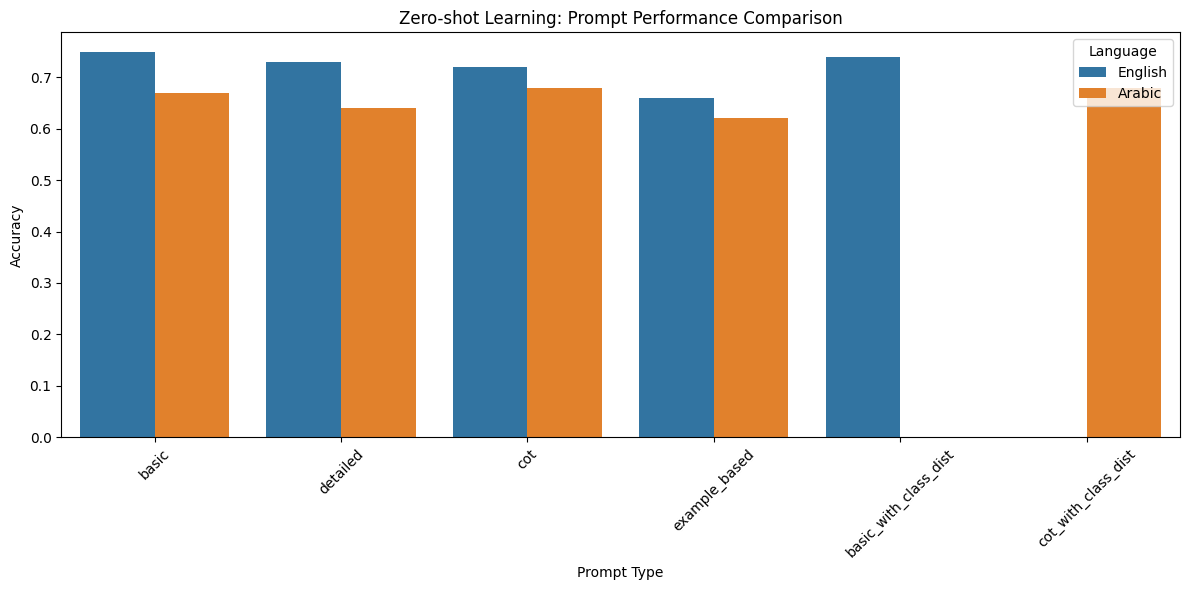


Best prompt: basic_with_class_dist with accuracy 0.7400


In [ ]:
# Zero-shot learning experiments
zero_shot_results = zero_shot_learning(train_df, val_df, possible_labels, n_samples=100)

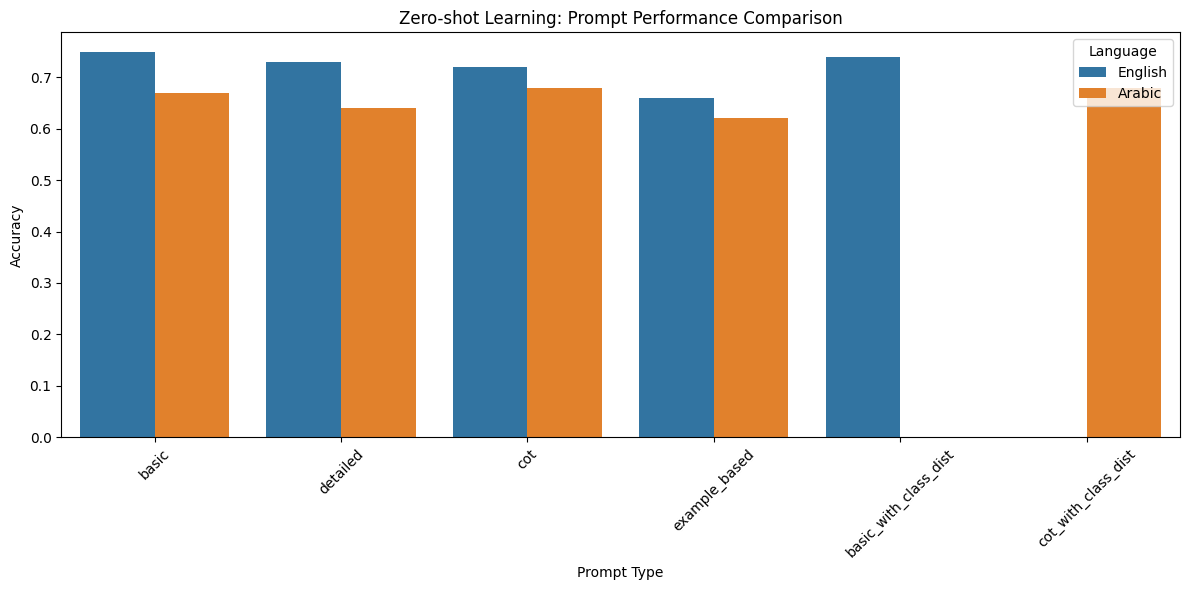

In [ ]:
  # Visualize results
  plot_zero_shot_results(zero_shot_results["english_results"], zero_shot_results["arabic_results"])

In [ ]:
def summarize_zero_shot_results(zero_shot_results):
    """
    Summarizes the zero-shot learning results into a DataFrame.

    Args:
        zero_shot_results: Output dictionary from zero_shot_learning()

    Returns:
        summary_df: Pandas DataFrame summarizing all prompt performances
    """
    def extract_macro_avg(report_text):
        """
        Extracts macro avg precision, recall, and f1-score from a classification_report string.
        Returns (precision, recall, f1) as floats.
        """
        if isinstance(report_text, dict):
            try:
                macro = report_text['macro avg']
                return macro['precision'], macro['recall'], macro['f1-score']
            except:
                return None, None, None

        # Regex pattern to match macro avg line
        pattern = r"macro avg\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)"
        match = re.search(pattern, report_text)
        if match:
            precision, recall, f1 = match.groups()
            return float(precision), float(recall), float(f1)

        return None, None, None

    def classification_report_parser(report_text):
        """
        Parses sklearn.metrics.classification_report into a dictionary.
        Works only when report is output in dictionary form or can be converted.
        """
        # If already a dict, return it
        if isinstance(report_text, dict):
            return report_text

        # Otherwise, parse the string-based report
        from io import StringIO
        import sys

        data = []
        for line in report_text.strip().split("\n"):
            if line.strip().startswith(('accuracy', 'macro avg', 'weighted avg')):
                parts = line.strip().split()
                if len(parts) == 5:
                    label, precision, recall, f1_score, support = parts
                    data.append([label, float(precision), float(recall), float(f1_score), int(support)])

        df = pd.DataFrame(data, columns=["Label", "Precision", "Recall", "F1-Score", "Support"])
        report_dict = df.set_index("Label").T.to_dict()
        return report_dict

    rows = []

    for name, result_set in [("English", zero_shot_results["english_results"]),
                             ("Arabic", zero_shot_results["arabic_results"])]:
        for prompt_name, data in result_set.items():
            precision, recall, f1 = extract_macro_avg(data["report"])
            rows.append({
                "Prompt Language": name,
                "Prompt Name": prompt_name,
                "Accuracy": data["accuracy"],
                "Macro Average Precision": precision,
                "Macro Average Recall": recall,
                "Macro Average F1-Score": f1
            })

    summary_df = pd.DataFrame(rows)
    summary_df.sort_values(by="Accuracy", ascending=False, inplace=True)
    summary_df.reset_index(drop=True, inplace=True)

    return summary_df

In [ ]:
summary_df = summarize_zero_shot_results(zero_shot_results)
display(summary_df)


,Prompt Language,Prompt Name,Accuracy,Macro Average Precision,Macro Average Recall,Macro Average F1-Score
0,English,basic,0.75,0.69,0.74,0.69
1,English,basic_with_class_dist,0.74,0.71,0.71,0.65
2,English,detailed,0.73,0.67,0.74,0.67
3,English,cot,0.72,0.66,0.76,0.67
4,Arabic,cot_with_class_dist,0.68,0.60,0.65,0.61
5,Arabic,cot,0.68,0.59,0.66,0.60
6,Arabic,basic,0.67,0.57,0.65,0.57
7,English,example_based,0.66,0.63,0.71,0.62
8,Arabic,detailed,0.64,0.56,0.62,0.57
9,Arabic,example_based,0.62,0.60,0.66,0.58


#### F.2 Few-shot learning

##### F.2.1 Prompt Design

In [ ]:
def generate_few_shot_prompt(train_examples, test_review, language="English", ordering="random"):
    """
    Generate a few-shot prompt with demonstration examples.

    Args:
        train_examples: List of training examples (review, label pairs)
        test_review: Test review text
        language: Language of the prompt
        ordering: Ordering strategy for examples

    Returns:
        prompt: Generated few-shot prompt
    """
    if language == "English":
        prompt = """
You are an expert in classifying app reviews. Given an app review, classify it into one of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Here are some examples:

"""
        for i, (review, label) in enumerate(train_examples):
            prompt += f"Example {i+1}:\nReview: \"{review}\"\nCategory: {label}\n\n"

        prompt += f"Now, classify the following review:\nReview: \"{test_review}\"\nCategory:"

    else:  # Arabic
        prompt = """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق، صنفها إلى إحدى هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

إليك بعض الأمثلة:

"""
        for i, (review, label) in enumerate(train_examples):
            prompt += f"مثال {i+1}:\nمراجعة: \"{review}\"\nالفئة: {label}\n\n"

        prompt += f"الآن، صنف المراجعة التالية:\nمراجعة: \"{test_review}\"\nالفئة:"

    return prompt

##### F.2.2 Prompt Engineering

In [ ]:
def select_examples_by_similarity(train_df, test_review, n_examples):
    """
    Select examples from training data based on similarity to test review.

    Args:
        train_df: Training DataFrame
        test_review: Test review text
        n_examples: Number of examples to select

    Returns:
        selected_examples: List of selected examples
    """
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)

    # Fit vectorizer on training data
    train_vectors = vectorizer.fit_transform(train_df['review'])

    # Transform test review
    test_vector = vectorizer.transform([test_review])

    # Calculate similarities
    similarities = cosine_similarity(test_vector, train_vectors).flatten()

    # Select top N examples
    top_indices = similarities.argsort()[-n_examples:][::-1]
    selected_examples = [(train_df.iloc[i]['review'], train_df.iloc[i]['Label']) for i in top_indices]

    return selected_examples

In [ ]:
def select_examples_by_class(train_df, n_examples):
    """
    Select examples from training data with balanced class representation.

    Args:
        train_df: Training DataFrame
        n_examples: Number of examples to select

    Returns:
        selected_examples: List of selected examples
    """
    # Get unique classes
    classes = train_df['Label'].unique()

    # Calculate examples per class
    examples_per_class = max(1, n_examples // len(classes))

    selected_examples = []
    for label in classes:
        class_df = train_df[train_df['Label'] == label]
        if len(class_df) > 0:
            class_samples = class_df.sample(min(examples_per_class, len(class_df)))
            for _, row in class_samples.iterrows():
                selected_examples.append((row['review'], row['Label']))

    # If we need more examples, sample randomly from the rest
    if len(selected_examples) < n_examples:
        remaining = n_examples - len(selected_examples)
        remaining_df = train_df[~train_df.index.isin([idx for _, idx in selected_examples])]
        if len(remaining_df) > 0:
            additional_samples = remaining_df.sample(min(remaining, len(remaining_df)))
            for _, row in additional_samples.iterrows():
                selected_examples.append((row['review'], row['Label']))

    return selected_examples

In [ ]:
def order_examples(examples, ordering="random"):
    """
    Order examples according to specified strategy.

    Args:
        examples: List of examples
        ordering: Ordering strategy

    Returns:
        ordered_examples: Ordered list of examples
    """
    if ordering == "random":
        random.shuffle(examples)
        return examples
    elif ordering == "by_label":
        return sorted(examples, key=lambda x: x[1])
    elif ordering == "by_length":
        return sorted(examples, key=lambda x: len(x[0]))
    else:
        return examples

In [ ]:
def evaluate_few_shot(train_df, val_df, possible_labels, n_shots_list, language="English", selection_method="random", ordering="random", n_samples=100):
    """
    Evaluate few-shot learning with different numbers of demonstration examples.

    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        n_shots_list: List of number of shots to try
        language: Language of the prompt
        selection_method: Method for selecting examples
        ordering: Ordering strategy for examples
        n_samples: Number of samples to evaluate on

    Returns:
        results: Dictionary with evaluation results
    """
    print(f"\n=== Few-shot Learning ({language}, {selection_method}, {ordering}) ===\n")

    # Sample from validation set
    if n_samples < len(val_df):
        val_sample = val_df.sample(n=n_samples, random_state=42)
    else:
        val_sample = val_df

    results = {}

    for n_shots in n_shots_list:
        print(f"\nEvaluating {n_shots}-shot learning")

        true_labels = []
        predictions = []

        for idx, row in tqdm(val_sample.iterrows(), total=len(val_sample), desc=f"{n_shots}-shot"):
            test_review = row['review']
            true_label = row['Label']
            true_labels.append(true_label)

            # Select examples
            if selection_method == "similarity":
                examples = select_examples_by_similarity(train_df, test_review, n_shots)
            elif selection_method == "by_class":
                examples = select_examples_by_class(train_df, n_shots)
            else:  # random
                examples = list(zip(train_df.sample(n=n_shots)['review'], train_df.sample(n=n_shots)['Label']))

            # Order examples
            examples = order_examples(examples, ordering)

            # Generate prompt
            prompt = generate_few_shot_prompt(examples, test_review, language, ordering)

            # Call API
            messages = [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ]

            response = call_llm_api(messages)
            predicted_label = parse_response(response, possible_labels)
            predictions.append(predicted_label)

            # Add small delay to avoid API rate limits
            time.sleep(0.5)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        report = classification_report(true_labels, predictions, target_names=possible_labels)

        print(f"\n{n_shots}-shot learning results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(report)

        results[n_shots] = {
            "accuracy": accuracy,
            "report": report,
            "predictions": predictions,
            "true_labels": true_labels
        }

    return results

In [ ]:
def plot_few_shot_results(results_dict, title):
    """
    Plot few-shot learning results.

    Args:
        results_dict: Dictionary with results
        title: Plot title
    """
    n_shots = list(results_dict.keys())
    accuracies = [results_dict[k]["accuracy"] for k in n_shots]

    plt.figure(figsize=(10, 6))
    plt.plot(n_shots, accuracies, marker='o', linestyle='-', linewidth=2)
    plt.title(title)
    plt.xlabel("Number of Demonstration Examples")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(n_shots)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

##### F.2.3 Prompt Execution and Evaluation

In [ ]:
def few_shot_learning(train_df, val_df, possible_labels, n_samples=100):
    """
    Perform few-shot learning experiments with different configurations.

    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        n_samples: Number of samples to evaluate on

    Returns:
        results: Dictionary with evaluation results
    """
    print("\n=== Few-shot Learning Experiments ===\n")

    # Define number of shots to try
    n_shots_list = [1, 2, 4, 8, 16]

    # Evaluate basic few-shot learning (English, random selection, random ordering)
    english_random_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "random", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_random_results, "Few-shot Learning: English, Random Selection")

    # Evaluate basic few-shot learning (Arabic, random selection, random ordering)
    arabic_random_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "Arabic", "random", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(arabic_random_results, "Few-shot Learning: Arabic, Random Selection")

    # BONUS: Evaluate few-shot learning with similarity-based selection
    english_similarity_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "similarity", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_similarity_results, "Few-shot Learning: English, Similarity Selection")

    # BONUS: Evaluate few-shot learning with class-based selection
    english_class_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "by_class", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_class_results, "Few-shot Learning: English, Class-based Selection")

    # BONUS: Evaluate few-shot learning with different ordering strategies
    english_ordered_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "random", "by_label", n_samples
    )

    # Plot results
    plot_few_shot_results(english_ordered_results, "Few-shot Learning: English, Ordered by Label")

    # Determine best configuration
    all_results = {
        "English, Random Selection": english_random_results,
        "Arabic, Random Selection": arabic_random_results,
        "English, Similarity Selection": english_similarity_results,
        "English, Class-based Selection": english_class_results,
        "English, Ordered by Label": english_ordered_results
    }

    best_configuration = None
    best_shots = None
    best_accuracy = 0

    for config_name, config_results in all_results.items():
        for n_shots, result in config_results.items():
            if result["accuracy"] > best_accuracy:
                best_accuracy = result["accuracy"]
                best_configuration = config_name
                best_shots = n_shots

    print(f"\nBest few-shot configuration: {best_configuration} with {best_shots} shots")
    print(f"Best accuracy: {best_accuracy:.4f}")

    return {
        "english_random": english_random_results,
        "arabic_random": arabic_random_results,
        "english_similarity": english_similarity_results,
        "english_class": english_class_results,
        "english_ordered": english_ordered_results,
        "best_configuration": best_configuration,
        "best_shots": best_shots,
        "best_accuracy": best_accuracy
    }


=== Few-shot Learning Experiments ===


=== Few-shot Learning (English, random, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]



1-shot learning results:
Accuracy: 0.6800
                     precision    recall  f1-score   support

         bug_report       0.70      0.88      0.78        26
             rating       0.33      1.00      0.50         9
improvement_request       0.62      0.42      0.50        12
             others       0.97      0.58      0.73        53

           accuracy                           0.68       100
          macro avg       0.66      0.72      0.63       100
       weighted avg       0.80      0.68      0.69       100


Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]



2-shot learning results:
Accuracy: 0.6500
                     precision    recall  f1-score   support

         bug_report       0.72      0.88      0.79        26
             rating       0.29      0.89      0.43         9
improvement_request       0.56      0.42      0.48        12
             others       0.94      0.55      0.69        53

           accuracy                           0.65       100
          macro avg       0.62      0.68      0.60       100
       weighted avg       0.78      0.65      0.67       100


Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]



4-shot learning results:
Accuracy: 0.6900
                     precision    recall  f1-score   support

         bug_report       0.74      0.88      0.81        26
             rating       0.31      1.00      0.47         9
improvement_request       0.75      0.50      0.60        12
             others       0.97      0.58      0.73        53

           accuracy                           0.69       100
          macro avg       0.69      0.74      0.65       100
       weighted avg       0.82      0.69      0.71       100


Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]



8-shot learning results:
Accuracy: 0.6500
                     precision    recall  f1-score   support

         bug_report       0.73      0.85      0.79        26
             rating       0.29      1.00      0.45         9
improvement_request       0.62      0.42      0.50        12
             others       0.94      0.55      0.69        53

           accuracy                           0.65       100
          macro avg       0.65      0.70      0.61       100
       weighted avg       0.79      0.65      0.67       100


Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it]



16-shot learning results:
Accuracy: 0.6000
                     precision    recall  f1-score   support

         bug_report       0.69      0.85      0.76        26
             rating       0.26      1.00      0.42         9
improvement_request       0.62      0.42      0.50        12
             others       0.92      0.45      0.61        53

           accuracy                           0.60       100
          macro avg       0.63      0.68      0.57       100
       weighted avg       0.77      0.60      0.62       100



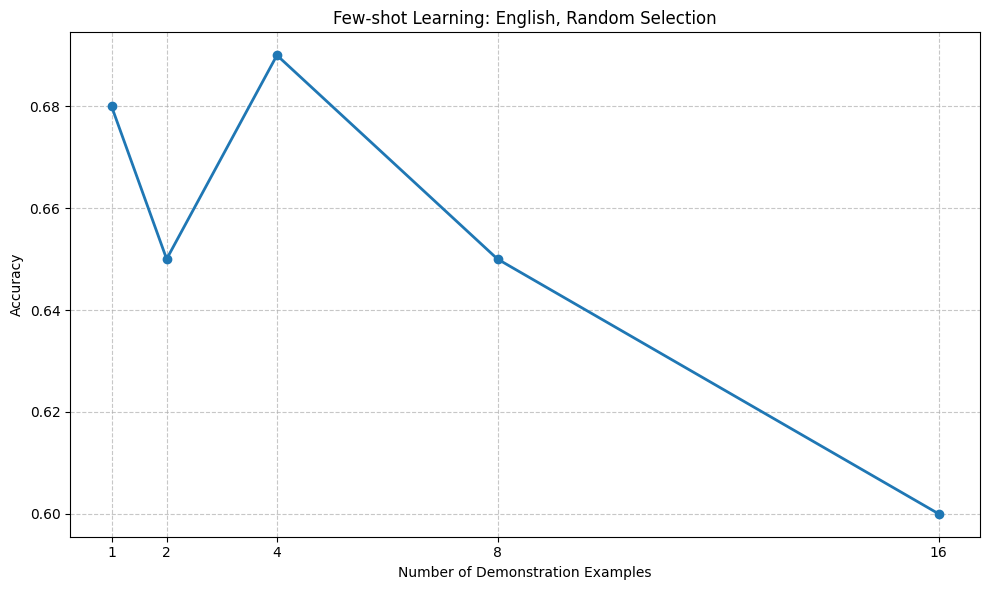


=== Few-shot Learning (Arabic, random, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]



1-shot learning results:
Accuracy: 0.6100
                     precision    recall  f1-score   support

         bug_report       0.61      0.77      0.68        26
             rating       0.23      0.67      0.34         9
improvement_request       0.50      0.42      0.45        12
             others       0.97      0.57      0.71        53

           accuracy                           0.61       100
          macro avg       0.58      0.60      0.55       100
       weighted avg       0.75      0.61      0.64       100


Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [02:42<00:00,  1.63s/it]



2-shot learning results:
Accuracy: 0.6500
                     precision    recall  f1-score   support

         bug_report       0.64      0.81      0.71        26
             rating       0.32      0.89      0.47         9
improvement_request       0.50      0.50      0.50        12
             others       1.00      0.57      0.72        53

           accuracy                           0.65       100
          macro avg       0.61      0.69      0.60       100
       weighted avg       0.78      0.65      0.67       100


Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]



4-shot learning results:
Accuracy: 0.6300
                     precision    recall  f1-score   support

         bug_report       0.67      0.77      0.71        26
             rating       0.32      1.00      0.49         9
improvement_request       0.43      0.50      0.46        12
             others       1.00      0.53      0.69        53

           accuracy                           0.63       100
          macro avg       0.60      0.70      0.59       100
       weighted avg       0.78      0.63      0.65       100


Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]



8-shot learning results:
Accuracy: 0.6300
                     precision    recall  f1-score   support

         bug_report       0.63      0.85      0.72        26
             rating       0.25      0.78      0.38         9
improvement_request       0.75      0.50      0.60        12
             others       0.97      0.53      0.68        53

           accuracy                           0.63       100
          macro avg       0.65      0.66      0.60       100
       weighted avg       0.79      0.63      0.66       100


Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]



16-shot learning results:
Accuracy: 0.6400
                     precision    recall  f1-score   support

         bug_report       0.62      0.81      0.70        26
             rating       0.31      0.89      0.46         9
improvement_request       0.55      0.50      0.52        12
             others       1.00      0.55      0.71        53

           accuracy                           0.64       100
          macro avg       0.62      0.69      0.60       100
       weighted avg       0.78      0.64      0.66       100



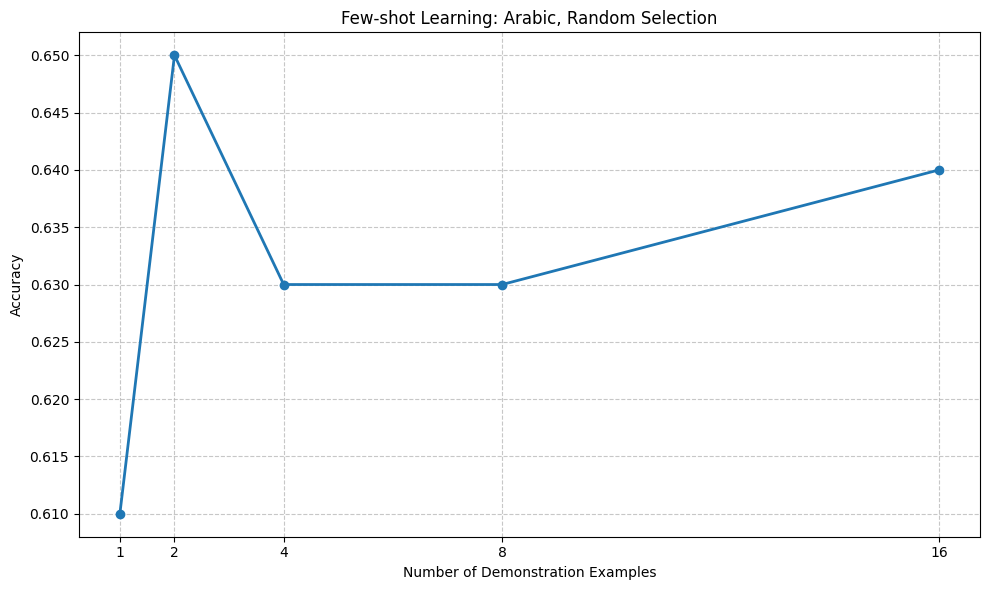


=== Few-shot Learning (English, similarity, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]



1-shot learning results:
Accuracy: 0.6600
                     precision    recall  f1-score   support

         bug_report       0.71      0.85      0.77        26
             rating       0.31      1.00      0.47         9
improvement_request       0.62      0.42      0.50        12
             others       0.94      0.57      0.71        53

           accuracy                           0.66       100
          macro avg       0.65      0.71      0.61       100
       weighted avg       0.78      0.66      0.68       100


Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]



2-shot learning results:
Accuracy: 0.6700
                     precision    recall  f1-score   support

         bug_report       0.70      0.88      0.78        26
             rating       0.33      1.00      0.50         9
improvement_request       0.57      0.33      0.42        12
             others       0.94      0.58      0.72        53

           accuracy                           0.67       100
          macro avg       0.64      0.70      0.61       100
       weighted avg       0.78      0.67      0.68       100


Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]



4-shot learning results:
Accuracy: 0.6800
                     precision    recall  f1-score   support

         bug_report       0.73      0.85      0.79        26
             rating       0.30      1.00      0.46         9
improvement_request       0.86      0.50      0.63        12
             others       0.94      0.58      0.72        53

           accuracy                           0.68       100
          macro avg       0.71      0.73      0.65       100
       weighted avg       0.82      0.68      0.70       100


Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]



8-shot learning results:
Accuracy: 0.6700
                     precision    recall  f1-score   support

         bug_report       0.70      0.88      0.78        26
             rating       0.31      1.00      0.47         9
improvement_request       1.00      0.33      0.50        12
             others       0.91      0.58      0.71        53

           accuracy                           0.67       100
          macro avg       0.73      0.70      0.62       100
       weighted avg       0.81      0.67      0.68       100


Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]



16-shot learning results:
Accuracy: 0.6900
                     precision    recall  f1-score   support

         bug_report       0.77      0.92      0.84        26
             rating       0.31      1.00      0.47         9
improvement_request       0.75      0.50      0.60        12
             others       0.94      0.57      0.71        53

           accuracy                           0.69       100
          macro avg       0.69      0.75      0.66       100
       weighted avg       0.82      0.69      0.71       100



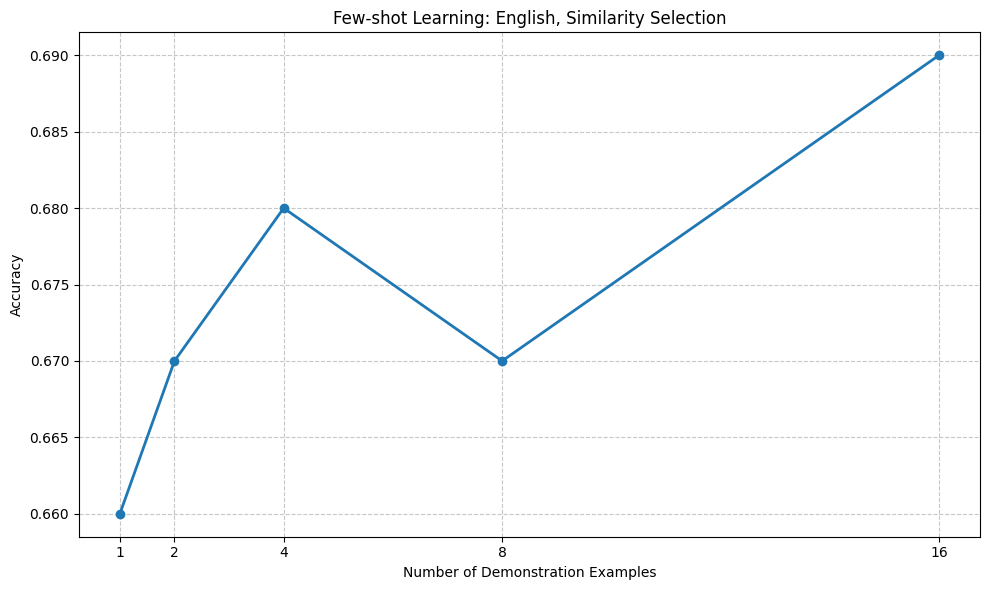


=== Few-shot Learning (English, by_class, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]



1-shot learning results:
Accuracy: 0.7200
                     precision    recall  f1-score   support

         bug_report       0.77      0.88      0.82        26
             rating       0.35      1.00      0.51         9
improvement_request       0.67      0.67      0.67        12
             others       1.00      0.60      0.75        53

           accuracy                           0.72       100
          macro avg       0.69      0.79      0.69       100
       weighted avg       0.84      0.72      0.74       100


Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]



2-shot learning results:
Accuracy: 0.6700
                     precision    recall  f1-score   support

         bug_report       0.76      0.85      0.80        26
             rating       0.29      0.89      0.43         9
improvement_request       0.55      0.50      0.52        12
             others       0.97      0.58      0.73        53

           accuracy                           0.67       100
          macro avg       0.64      0.70      0.62       100
       weighted avg       0.80      0.67      0.70       100


Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]



4-shot learning results:
Accuracy: 0.6900
                     precision    recall  f1-score   support

         bug_report       0.73      0.85      0.79        26
             rating       0.35      1.00      0.51         9
improvement_request       0.55      0.50      0.52        12
             others       0.97      0.60      0.74        53

           accuracy                           0.69       100
          macro avg       0.65      0.74      0.64       100
       weighted avg       0.80      0.69      0.71       100


Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]



8-shot learning results:
Accuracy: 0.6200
                     precision    recall  f1-score   support

         bug_report       0.71      0.85      0.77        26
             rating       0.26      1.00      0.42         9
improvement_request       0.57      0.33      0.42        12
             others       0.96      0.51      0.67        53

           accuracy                           0.62       100
          macro avg       0.63      0.67      0.57       100
       weighted avg       0.79      0.62      0.64       100


Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [02:37<00:00,  1.58s/it]



16-shot learning results:
Accuracy: 0.6300
                     precision    recall  f1-score   support

         bug_report       0.66      0.81      0.72        26
             rating       0.30      1.00      0.46         9
improvement_request       0.62      0.42      0.50        12
             others       0.93      0.53      0.67        53

           accuracy                           0.63       100
          macro avg       0.63      0.69      0.59       100
       weighted avg       0.77      0.63      0.65       100



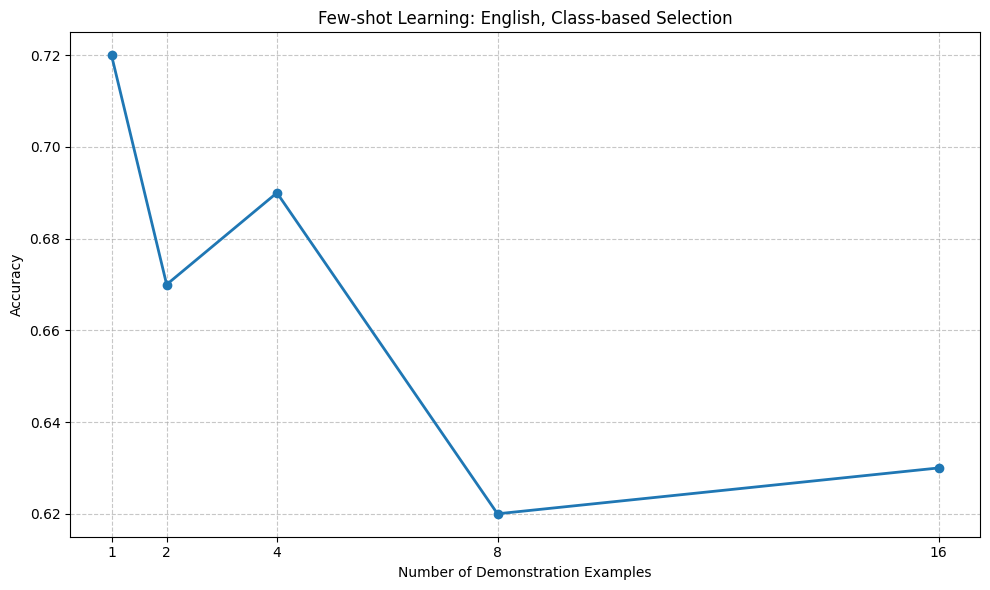


=== Few-shot Learning (English, random, by_label) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [02:53<00:00,  1.74s/it]



1-shot learning results:
Accuracy: 0.6500
                     precision    recall  f1-score   support

         bug_report       0.77      0.88      0.82        26
             rating       0.31      1.00      0.47         9
improvement_request       0.45      0.42      0.43        12
             others       0.93      0.53      0.67        53

           accuracy                           0.65       100
          macro avg       0.62      0.71      0.60       100
       weighted avg       0.78      0.65      0.67       100


Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]



2-shot learning results:
Accuracy: 0.6600
                     precision    recall  f1-score   support

         bug_report       0.71      0.85      0.77        26
             rating       0.29      1.00      0.45         9
improvement_request       0.75      0.50      0.60        12
             others       0.97      0.55      0.70        53

           accuracy                           0.66       100
          macro avg       0.68      0.72      0.63       100
       weighted avg       0.81      0.66      0.68       100


Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]



4-shot learning results:
Accuracy: 0.6800
                     precision    recall  f1-score   support

         bug_report       0.77      0.88      0.82        26
             rating       0.30      1.00      0.46         9
improvement_request       0.67      0.67      0.67        12
             others       1.00      0.53      0.69        53

           accuracy                           0.68       100
          macro avg       0.68      0.77      0.66       100
       weighted avg       0.84      0.68      0.70       100


Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]



8-shot learning results:
Accuracy: 0.6100
                     precision    recall  f1-score   support

         bug_report       0.69      0.85      0.76        26
             rating       0.27      1.00      0.43         9
improvement_request       0.57      0.33      0.42        12
             others       0.93      0.49      0.64        53

           accuracy                           0.61       100
          macro avg       0.62      0.67      0.56       100
       weighted avg       0.76      0.61      0.63       100


Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [04:42<00:00,  2.83s/it]



16-shot learning results:
Accuracy: 0.6400
                     precision    recall  f1-score   support

         bug_report       0.74      0.88      0.81        26
             rating       0.28      1.00      0.44         9
improvement_request       0.56      0.42      0.48        12
             others       0.96      0.51      0.67        53

           accuracy                           0.64       100
          macro avg       0.64      0.70      0.60       100
       weighted avg       0.80      0.64      0.66       100



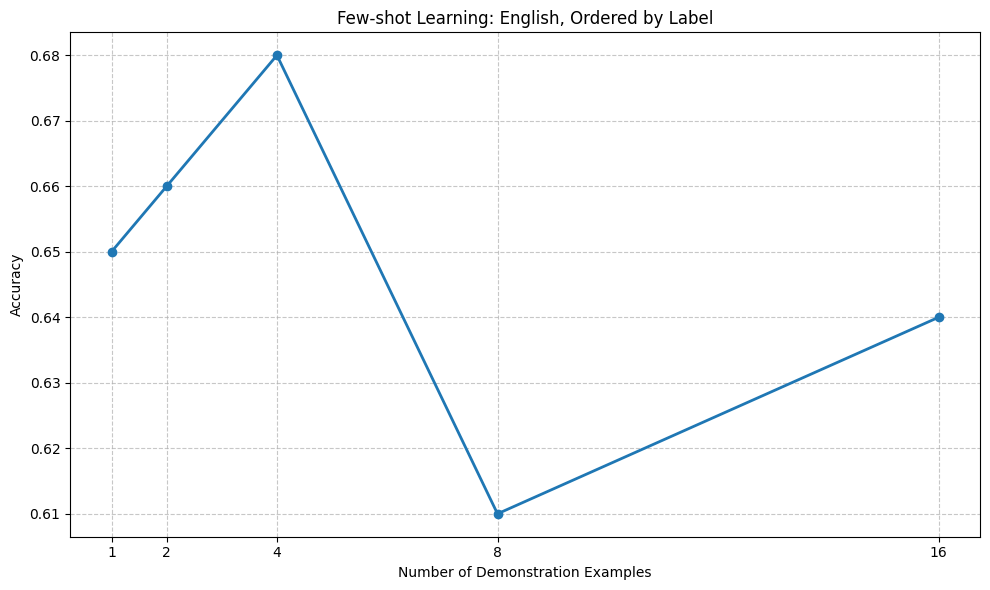


Best few-shot configuration: English, Class-based Selection with 1 shots
Best accuracy: 0.7200


In [ ]:
# Few-shot learning experiments
few_shot_results = few_shot_learning(train_df, val_df, possible_labels, n_samples=100)

In [ ]:
def plot_all_few_shot_results(few_shot_results):
    """
    Plot accuracy vs. number of shots for all few-shot learning configurations.
    """
    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v']

    configs = {
        "English, Random Selection": few_shot_results["english_random"],
        "Arabic, Random Selection": few_shot_results["arabic_random"],
        "English, Similarity Selection": few_shot_results["english_similarity"],
        "English, Class-based Selection": few_shot_results["english_class"],
        "English, Ordered by Label": few_shot_results["english_ordered"]
    }

    for i, (label, config) in enumerate(configs.items()):
        x = list(config.keys())
        y = [config[shots]["accuracy"] for shots in x]
        plt.plot(x, y, marker=markers[i % len(markers)], label=label)

    plt.title("Few-shot Learning: Accuracy vs. Number of Shots")
    plt.xlabel("Number of Shots")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

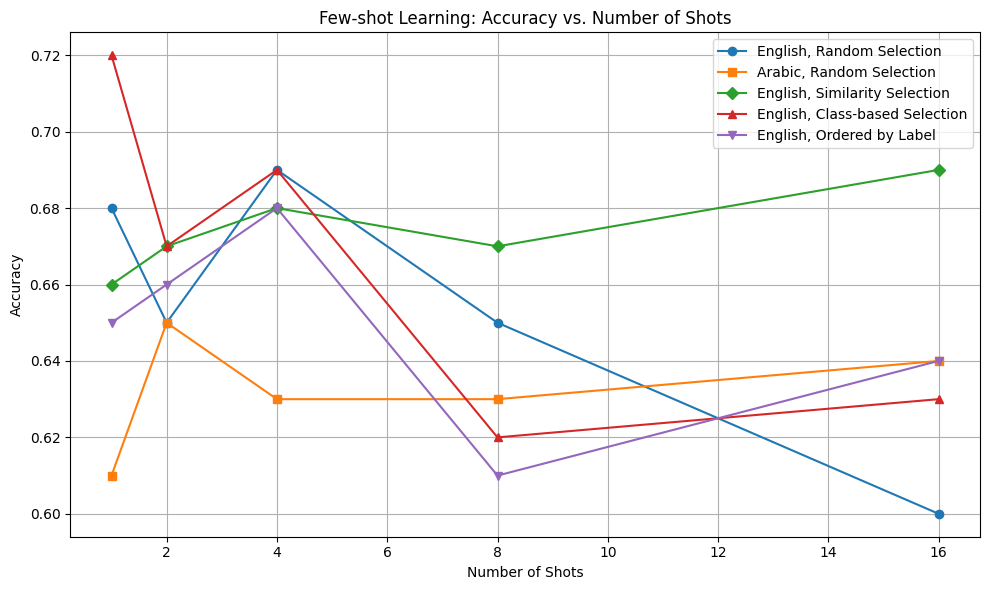

In [ ]:
plot_all_few_shot_results(few_shot_results)

In [ ]:
def format_few_shot_results_table(few_shot_results):
    """
    Format few-shot learning results into a DataFrame similar to the zero-shot results table.
    """
    rows = []

    config_mappings = {
        "english_random": ("English", "random"),
        "arabic_random": ("Arabic", "random"),
        "english_similarity": ("English", "similarity"),
        "english_class": ("English", "by_class"),
        "english_ordered": ("English", "by_label")
    }

    for key, results in few_shot_results.items():
        if key.startswith("best_"):
            continue  # Skip meta-entries

        language, strategy = config_mappings.get(key, ("Unknown", "Unknown"))

        # Find best number of shots based on accuracy
        best_shot = max(results.items(), key=lambda x: x[1].get("accuracy", 0))[0]
        best_result = results[best_shot]

        row = {
            "Prompt Language": language,
            "Prompt Strategy": strategy,
            "Shots": best_shot,
            "Accuracy": round(best_result.get("accuracy", 0), 4),
            "Macro Precision": round(best_result.get("macro_precision", 0), 4) if best_result.get("macro_precision") is not None else None,
            "Macro Recall": round(best_result.get("macro_recall", 0), 4) if best_result.get("macro_recall") is not None else None,
            "Macro F1-Score": round(best_result.get("macro_f1", 0), 4) if best_result.get("macro_f1") is not None else None,
        }
        rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
table_df = format_few_shot_results_table(few_shot_results)
display(table_df)


,Prompt Language,Prompt Strategy,Shots,Accuracy,Macro Precision,Macro Recall,Macro F1-Score
0,English,random,4,0.69,None,None,None
1,Arabic,random,2,0.65,None,None,None
2,English,similarity,16,0.69,None,None,None
3,English,by_class,1,0.72,None,None,None
4,English,by_label,4,0.68,None,None,None


#### F.3 Zero-shot VS Few-shot

In [ ]:
# Compare best zero-shot and few-shot results
print("\n=== Comparison of Best Zero-shot and Few-shot Results ===\n")
print(f"Best zero-shot: {zero_shot_results['best_prompt']} with accuracy {zero_shot_results['best_accuracy']:.4f}")
print(f"Best few-shot: {few_shot_results['best_configuration']} with {few_shot_results['best_shots']} shots and accuracy {few_shot_results['best_accuracy']:.4f}")




=== Comparison of Best Zero-shot and Few-shot Results ===

Best zero-shot: basic_with_class_dist with accuracy 0.7400
Best few-shot: English, Class-based Selection with 1 shots and accuracy 0.7200


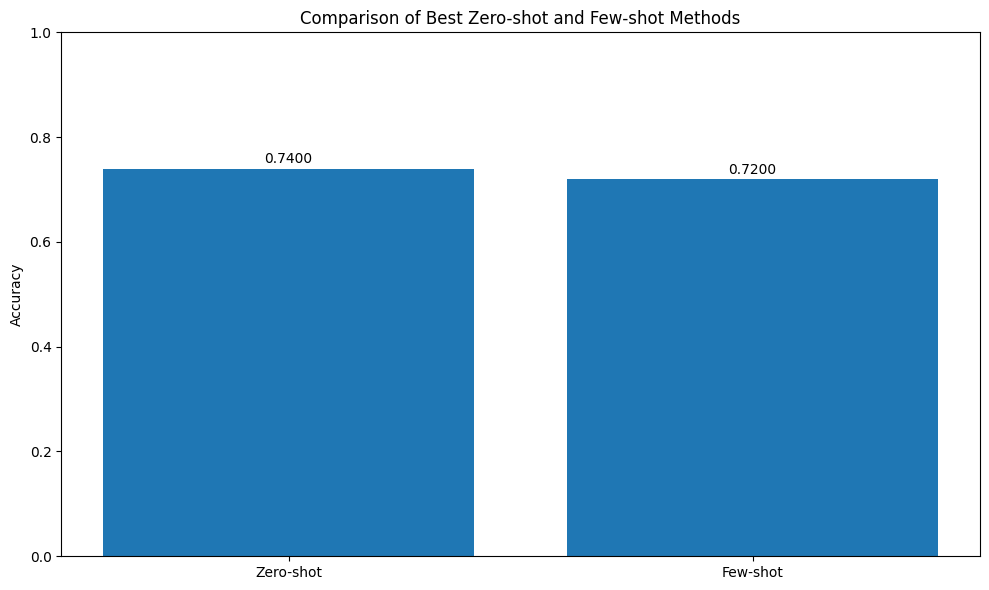

In [ ]:
# Plot comparison
plt.figure(figsize=(10, 6))
methods = ["Zero-shot", "Few-shot"]
accuracies = [zero_shot_results['best_accuracy'], few_shot_results['best_accuracy']]

plt.bar(methods, accuracies)
plt.title("Comparison of Best Zero-shot and Few-shot Methods")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Add accuracy values on top of bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

## Part-G: Multilabel App Review Classification: In-Context learning using causal LLM


#### G.1 Zero-shot learning

##### G.1.1 API setup

In [ ]:
import secret
import openai

openai.api_key = secret.get_openai_key()
client = openai.OpenAI(api_key=openai.api_key)


##### G.1.2 Data Loading and Splitting

In [ ]:
def load_data(file_path="App Reviews-Multilabel.csv"):
    """
    Load the app review dataset (multilabel) and split into train, validation, and test sets.

    Args:
        file_path: Path to the CSV file.

    Returns:
        train_df, val_df, test_df: DataFrames for training, validation, and testing.
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)

    # Check if data is loaded correctly
    print(f"Dataset shape: {df.shape}")
    display(df.head())

    # Define label columns
    label_cols = df.columns[-4:]  # Get the last 4 columns
    print("\nLabel columns:", label_cols)

    # Check label distribution for each label column
    print("\nLabel distribution:")
    for label_col in label_cols:
        class_dist = df[label_col].value_counts(normalize=True)
        print(f"  {label_col}:")
        print(class_dist)

    # First: Train-Test Split (80-20)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

    # Second: Validation Split from Train (15% of train)
    train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED)

    print(f"\nTrain set: {train_df.shape[0]} samples")
    print(f"Validation set: {val_df.shape[0]} samples")
    print(f"Test set: {test_df.shape[0]} samples")

    return train_df, val_df, test_df

##### G.1.3 Class Distribution

In [ ]:
def get_class_distribution(train_df):
    """
    Calculate class distribution for multilabel data.

    Args:
        train_df: Training DataFrame

    Returns:
        class_dist: Dictionary with class distribution information
    """
    label_cols = train_df.columns[-4:]  # Get the last 4 columns as label columns

    class_dist = {}
    for label_col in label_cols:
        class_counts = train_df[label_col].value_counts()
        total = class_counts.sum()
        class_dist[label_col] = {
            label: f"{count} ({count/total:.1%})" for label, count in class_counts.items()
        }

    return class_dist

##### G.1.4 API Call

In [ ]:
# Function to call the LLM API with retry mechanism
def call_llm_api(messages, model="gpt-3.5-turbo", temperature=0, max_retries=3, delay=2):
    """
    Call the LLM API with retry mechanism.

    Args:
        messages: List of message dictionaries
        model: LLM model to use
        temperature: Temperature parameter for generation
        max_retries: Maximum number of retries
        delay: Delay between retries

    Returns:
        response_text: Text response from the LLM
    """
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
            )
            if response and response.choices:
                content = response.choices[0].message.content
                if content is not None:
                    return content.strip()
            return "Error: Empty response"
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"Attempt {attempt + 1} failed: {str(e)}. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                return f"Error after {max_retries} attempts: {str(e)}"


##### G.1.5 Response Foramtting

In [ ]:
def parse_response(response, possible_labels):
    """
    Parse LLM response to extract predicted labels for multilabel classification.

    Args:
        response: Raw response from the LLM
        possible_labels: List of possible class labels

    Returns:
        predicted_labels: List of extracted labels from the response
    """
    response = response.lower()
    predicted_labels = []

    # Try to find JSON format
    json_pattern = r'\{.*\}'
    json_match = re.search(json_pattern, response, re.DOTALL)
    if json_match:
        try:
            json_data = json.loads(json_match.group())
            if 'labels' in json_data:  # Check for "labels" key
                predicted_labels.extend(json_data['labels'])
                return predicted_labels  # Return early if JSON is found
        except:
            pass

    # Direct search for labels with thresholding
    for label in possible_labels:
        if label.lower() in response:  # If label is present
            predicted_labels.append(label)  # Add it to predicted labels

    # Add keyword-based logic
    if not predicted_labels:  # If no labels found through direct search
        if 'bug' in response or 'error' in response or 'crash' in response or 'not working' in response:
            predicted_labels.append('bug_report')
        if 'improve' in response or 'request' in response or 'feature' in response or 'suggestion' in response:
            predicted_labels.append('improvement_request')
        if 'star' in response or 'rate' in response or 'good' in response or 'great' in response or 'bad' in response:
            predicted_labels.append('rating')

    # If still no labels found, default to "others"
    if not predicted_labels:
        predicted_labels.append('others')

    return predicted_labels

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
SEED = 777
# Load and prepare data
train_df, val_df, test_df = load_data()

# Define possible labels
possible_labels = ["bug_report", "rating", "improvement_request", "others"]

Loading data from App Reviews-Multilabel.csv...
Dataset shape: (2900, 5)


,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1



Label columns: Index(['bug_report', 'improvement_request', 'rating', 'others'], dtype='object')

Label distribution:
  bug_report:
bug_report
0    0.598621
1    0.401379
Name: proportion, dtype: float64
  improvement_request:
improvement_request
0    0.619655
1    0.380345
Name: proportion, dtype: float64
  rating:
rating
1    0.679655
0    0.320345
Name: proportion, dtype: float64
  others:
others
0    0.717241
1    0.282759
Name: proportion, dtype: float64

Train set: 1972 samples
Validation set: 348 samples
Test set: 580 samples


##### G.1.6 Prompt Design

In [ ]:
def get_zero_shot_prompts_english():
    """
    Define different prompt templates for zero-shot learning in English.

    Returns:
        prompts_dict: Dictionary of prompts
    """
    prompts = {
        "basic": """
You are an expert in classifying app reviews. Given the following app review, classify it into one or more of these categories:
- bug_report: Reports of bugs or technical issues in the app
- improvement_request: Suggestions for new features or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction
- others: Reviews that don't fall into any of the above categories

App Review: "{review}"

Return a comma-separated list of category labels.
""",

        "detailed": """
You are an expert in classifying app reviews. Given the following app review, classify it into one or more of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Analyze the review carefully for mentions of technical problems, suggestions for improvements, or expressions of satisfaction/dissatisfaction.

App Review: "{review}"

Provide your classification in this format:
{{
  "labels": ["category_name1", "category_name2", ...]
}}
""",

        "cot": """
You are an expert in classifying app reviews. Given the following app review, classify it into one or more of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Think step by step:
1. What is the main point of this review?
2. Does it mention any bugs, errors or technical issues? If yes, add "bug_report" to the list of labels.
3. Does it suggest new features or improvements? If yes, add "improvement_request" to the list of labels.
4. Does it express satisfaction or dissatisfaction with the app? If yes, add "rating" to the list of labels.
5. If the review doesn't fit any of the above categories, add "others" to the list of labels.

App Review: "{review}"

Provide your classification in this format:
{{
  "labels": ["category_name1", "category_name2", ...]
}}
""",

    "example_based": """
You are an expert in classifying app reviews. Given the following app review, classify it into one or more of these categories:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Here are some examples of each category:
- bug_report: "The app keeps crashing when I try to upload photos." or "Cannot login, it shows error message."
- improvement_request: "Please add dark mode" or "It would be nice if we could customize the interface."
- rating: "Great app, love it!" or "This app is terrible, don't waste your time."
- others: "Does this work on iPad?" or "What's your privacy policy?"

Here are some examples of reviews with multiple categories:
- "The app is great, but it crashes sometimes. Please fix the bug!" (rating, bug_report)
- "I love the new features, but it would be even better with dark mode." (rating, improvement_request)

App Review: "{review}"

Provide your classification in this format:
{{
  "labels": ["category_name1", "category_name2", ...]
}}
""",
    }

    return prompts

In [ ]:
# Define different prompts for zero-shot learning in Arabic
def get_zero_shot_prompts_arabic():
    """
    Define different prompt templates for zero-shot learning in Arabic.

    Returns:
        prompts_dict: Dictionary of prompts
    """
    prompts = {
        "basic": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى فئة أو أكثر من هذه الفئات:
- bug_report: تقارير عن أخطاء أو مشاكل تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

مراجعة التطبيق: "{review}"

أعد قائمة بأسماء الفئات مفصولة بفواصل.
""",

        "detailed": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى فئة أو أكثر من هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

حلل المراجعة بعناية بحثاً عن ذكر المشاكل التقنية، اقتراحات للتحسينات، أو تعبيرات عن الرضا/عدم الرضا.

مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "labels": ["اسم_الفئة2", "اسم_الفئة1", ...]
}}
""",

        "cot": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى فئة أو أكثر من هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

فكر خطوة بخطوة:
1. ما هي النقطة الرئيسية لهذه المراجعة؟
2. هل تذكر أي أخطاء، مشاكل أو قضايا تقنية؟ إذا كانت الإجابة بنعم، أضف "bug_report" إلى قائمة التصنيفات.
3. هل تقترح ميزات جديدة أو تحسينات؟ إذا كانت الإجابة بنعم، أضف "improvement_request" إلى قائمة التصنيفات.
4. هل تعبر عن الرضا أو عدم الرضا مع التطبيق؟ إذا كانت الإجابة بنعم، أضف "rating" إلى قائمة التصنيفات.
5. إذا كانت المراجعة لا تتناسب مع أي من الفئات المذكورة أعلاه، أضف "others" إلى قائمة التصنيفات.
# إذا كانت المراجعة لا تتناسب مع أي من الفئات المذكورة أعلاه، أضف "others" إلى قائمة التصنيفات. # تم إزالة هذا السطر لتصحيح الخطأ

مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "labels": ["اسم_الفئة2", "اسم_الفئة1", ...]
}}
""",

    "example_based": """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق التالية، صنفها إلى فئة أو أكثر من هذه الفئات:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

إليك بعض الأمثلة لكل فئة:
- bug_report: "التطبيق يتوقف عندما أحاول تحميل الصور." أو "لا يمكنني تسجيل الدخول، تظهر رسالة خطأ."
- improvement_request: "الرجاء إضافة الوضع المظلم" أو "سيكون من الجيد لو استطعنا تخصيص الواجهة."
- rating: "تطبيق رائع، أحبه!" أو "هذا التطبيق فظيع، لا تضيع وقتك."
- others: "هل يعمل هذا على iPad؟" أو "ما هي سياسة الخصوصية الخاصة بك؟"

إليك بعض الأمثلة على المراجعات التي تحتوي على فئات متعددة:
- "التطبيق رائع، لكنه يتوقف أحيانًا. الرجاء إصلاح الخطأ!" (rating, bug_report)
- "أحب الميزات الجديدة، لكن سيكون من الأفضل لو كان هناك وضع مظلم." (rating, improvement_request)


مراجعة التطبيق: "{review}"

قدم تصنيفك بهذا الشكل:
{{
  "labels": ["اسم_الفئة2", "اسم_الفئة1", ...]
}}
""",
    }

    return prompts

##### G.1.7 Adding Class Distribution to LLM

In [ ]:
def add_class_distribution_to_prompt(prompt_template, class_dist):
    """
    Add class distribution information for multilabel data to a prompt.

    Args:
        prompt_template: Base prompt template
        class_dist: Dictionary with class distribution information

    Returns:
        modified_prompt: Prompt with class distribution
    """
    dist_text = "Based on our training data, the distribution of classes is as follows:\n"
    for label_col, dist in class_dist.items():
        dist_text += f"**{label_col}:**\n"  # Add label column name
        for label, percentage in dist.items():
            dist_text += f"- {label}: {percentage}\n"
        dist_text += "\n"  # Add a separator between label columns

    # Insert the distribution information before the review
    if "App Review:" in prompt_template:
        modified_prompt = prompt_template.replace("App Review:", dist_text + "\nApp Review:")
    elif "مراجعة التطبيق:" in prompt_template:
        modified_prompt = prompt_template.replace("مراجعة التطبيق:", dist_text + "\nمراجعة التطبيق:")
    else:
        modified_prompt = prompt_template + "\n" + dist_text

    return modified_prompt

##### G.1.8 Prompt Evaluation

In [ ]:
def evaluate_zero_shot_prompt(prompt_template, val_df, possible_labels, language="English", include_class_dist=False, class_dist=None, n_samples=100):
    """
    Evaluate a zero-shot prompt on validation data for multilabel classification.

    Args:
        prompt_template: Prompt template to evaluate
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        language: Language of the prompt
        include_class_dist: Whether to include class distribution
        class_dist: Dictionary with class distribution information
        n_samples: Number of samples to evaluate on

    Returns:
        report: Classification report
        predictions: List of predictions
    """
    # Sample from validation set
    if n_samples < len(val_df):
        sampled_df = val_df.sample(n=n_samples, random_state=42)
    else:
        sampled_df = val_df

    true_labels = sampled_df[possible_labels].values.tolist()  # Get true labels as a list of lists
    predictions = []

    # If class distribution should be included
    if include_class_dist and class_dist:
        modified_prompt = add_class_distribution_to_prompt(prompt_template, class_dist)
    else:
        modified_prompt = prompt_template

    # Run inference
    for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc=f"Evaluating {language} prompt"):
        review = row['review']
        prompt = modified_prompt.format(review=review)

        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]

        response = call_llm_api(messages)
        predicted_label = parse_response(response, possible_labels)
        predictions.append(predicted_label)

        # Add small delay to avoid API rate limits
        time.sleep(0.5)

    # Calculate metrics using classification_report for multilabel
    report = classification_report(true_labels, [[l in p for l in possible_labels] for p in predictions], target_names=possible_labels, zero_division=0, output_dict=True)  # Add output_dict=True
    report_df = pd.DataFrame.from_dict(report).T
    report_df = report_df.style.format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score', 'support']])  # Format specific columns
    display(report_df)
    return report, predictions

In [ ]:
def plot_zero_shot_results(english_results, arabic_results, metrics=['precision', 'recall', 'f1-score']):
    """
    Plot zero-shot learning results for multilabel classification.

    Args:
        english_results: Dictionary with English prompt results
        arabic_results: Dictionary with Arabic prompt results
        metrics: List of metrics to plot (default: ['precision', 'recall', 'f1-score'])
    """
    # Prepare data for plotting
    prompt_names = []
    metric_values = []
    languages = []
    metric_names = []

    for prompt_name, results in english_results.items():
        for metric in metrics:

            metric_value = results["report"].get('weighted avg', {}).get(metric, 0)  # Handle missing metrics using .get()
            prompt_names.append(prompt_name)
            metric_values.append(metric_value)
            languages.append("English")
            metric_names.append(metric.capitalize())  # Capitalize metric names for better display

    for prompt_name, results in arabic_results.items():
        for metric in metrics:
            metric_value = results["report"].get('weighted avg', {}).get(metric, 0)
            prompt_names.append(prompt_name)
            metric_values.append(metric_value)
            languages.append("Arabic")
            metric_names.append(metric.capitalize())

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        "Prompt": prompt_names,
        "Metric": metric_names,
        "Value": metric_values,
        "Language": languages
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Prompt", y="Value", hue="Language", data=plot_df, ci=None)
    plt.title("Zero-shot Learning: Prompt Performance Comparison (Multilabel)")
    plt.xlabel("Prompt Type")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("zero_shot_results_multilabel.png")
    plt.show()

In [ ]:
def zero_shot_learning(train_df, val_df, possible_labels, n_samples=100):
    """
    Perform zero-shot learning experiments with different prompts for multilabel classification.

    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        n_samples: Number of samples to evaluate on

    Returns:
        results: Dictionary with evaluation results
    """
    print("\n=== Zero-shot Learning Experiments (Multilabel) ===\n")

    # Get class distribution for bonus task
    class_dist = get_class_distribution(train_df)  # Pass possible_labels
    print(f"Class distribution: {class_dist}")

    # Get prompts
    english_prompts = get_zero_shot_prompts_english()
    arabic_prompts = get_zero_shot_prompts_arabic()

    # Evaluate English prompts
    english_results = {}
    for prompt_name, prompt_template in english_prompts.items():
        print(f"\nEvaluating English prompt: {prompt_name}")
        report, predictions = evaluate_zero_shot_prompt(
            prompt_template, val_df, possible_labels, "English", False, None, n_samples
        )
        english_results[prompt_name] = {
            "report": report,
            "predictions": predictions
        }

    # Evaluate Arabic prompts
    arabic_results = {}
    for prompt_name, prompt_template in arabic_prompts.items():
        print(f"\nEvaluating Arabic prompt: {prompt_name}")
        report, predictions = evaluate_zero_shot_prompt(
            prompt_template, val_df, possible_labels, "Arabic", False, None, n_samples
        )
        arabic_results[prompt_name] = {
            "report": report,
            "predictions": predictions
        }

    # BONUS: Evaluate best prompt with class distribution
    all_results = {**english_results, **arabic_results}
    best_english_prompt = max(english_results, key=lambda k: english_results[k]["report"].get("weighted avg", {}).get("f1-score", 0))

    # Find the best Arabic prompt
    best_arabic_prompt = max(arabic_results, key=lambda k: arabic_results[k]["report"].get("weighted avg", {}).get("f1-score", 0))

    # Compare the best English and Arabic prompts
    if english_results[best_english_prompt]["report"].get("weighted avg", {}).get("f1-score", 0) > \
       arabic_results[best_arabic_prompt]["report"].get("weighted avg", {}).get("f1-score", 0):
        best_prompt_name = best_english_prompt
    else:
        best_prompt_name = best_arabic_prompt

    # Get the best prompt template and language
    if best_prompt_name in english_results:
        best_prompt_template = english_prompts[best_prompt_name]
        best_prompt_language = "English"
    else:
        best_prompt_template = arabic_prompts[best_prompt_name]
        best_prompt_language = "Arabic"

    print(f"\nBONUS: Evaluating best overall prompt ({best_prompt_name}) with class distribution")
    report, predictions = evaluate_zero_shot_prompt(
        best_prompt_template, val_df, possible_labels,
        f"{best_prompt_language} with class dist", True, class_dist, n_samples
    )

    # Store results for the best prompt with class distribution
    if best_prompt_language == "English":
        english_results[f"{best_prompt_name}_with_class_dist"] = {
            "report": report,
            "predictions": predictions
        }
    else:
        arabic_results[f"{best_prompt_name}_with_class_dist"] = {
            "report": report,
            "predictions": predictions
        }

    return english_results, arabic_results

In [ ]:
# Zero-shot learning experiments
english_results, arabic_results = zero_shot_learning(train_df, val_df, possible_labels, n_samples=100)


=== Zero-shot Learning Experiments (Multilabel) ===

Class distribution: {'bug_report': {0: '1193 (60.5%)', 1: '779 (39.5%)'}, 'improvement_request': {0: '1247 (63.2%)', 1: '725 (36.8%)'}, 'rating': {1: '1350 (68.5%)', 0: '622 (31.5%)'}, 'others': {0: '1413 (71.7%)', 1: '559 (28.3%)'}}

Evaluating English prompt: basic


Evaluating English prompt: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.59,0.74,34.00
rating,0.96,0.68,0.80,72.00
improvement_request,0.79,0.42,0.55,36.00
others,0.71,0.36,0.48,28.00
micro avg,0.90,0.55,0.69,170.00
macro avg,0.87,0.51,0.64,170.00
weighted avg,0.89,0.55,0.68,170.00
samples avg,0.91,0.65,0.72,170.00



Evaluating English prompt: detailed


Evaluating English prompt: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.76,0.87,34.00
rating,1.00,0.64,0.78,72.00
improvement_request,0.86,0.53,0.66,36.00
others,0.71,0.36,0.48,28.00
micro avg,0.94,0.59,0.73,170.00
macro avg,0.89,0.57,0.69,170.00
weighted avg,0.92,0.59,0.72,170.00
samples avg,0.93,0.67,0.75,170.00



Evaluating English prompt: cot


Evaluating English prompt: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.62,0.76,34.00
rating,1.00,0.51,0.68,72.00
improvement_request,1.00,0.33,0.50,36.00
others,0.49,0.64,0.55,28.00
micro avg,0.82,0.52,0.64,170.00
macro avg,0.87,0.53,0.62,170.00
weighted avg,0.92,0.52,0.64,170.00
samples avg,0.81,0.59,0.66,170.00



Evaluating English prompt: example_based


Evaluating English prompt: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.50,0.67,34.00
rating,1.00,0.56,0.71,72.00
improvement_request,1.00,0.39,0.56,36.00
others,0.59,0.79,0.68,28.00
micro avg,0.86,0.55,0.67,170.00
macro avg,0.90,0.56,0.65,170.00
weighted avg,0.93,0.55,0.67,170.00
samples avg,0.85,0.63,0.70,170.00



Evaluating Arabic prompt: basic


Evaluating Arabic prompt: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


,precision,recall,f1-score,support
bug_report,0.83,0.71,0.76,34.00
rating,1.00,0.54,0.70,72.00
improvement_request,0.90,0.25,0.39,36.00
others,0.42,0.64,0.51,28.00
micro avg,0.74,0.53,0.62,170.00
macro avg,0.79,0.54,0.59,170.00
weighted avg,0.85,0.53,0.62,170.00
samples avg,0.78,0.60,0.65,170.00



Evaluating Arabic prompt: detailed


Evaluating Arabic prompt: 100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


,precision,recall,f1-score,support
bug_report,0.83,0.71,0.76,34.00
rating,1.00,0.62,0.77,72.00
improvement_request,0.71,0.42,0.53,36.00
others,0.67,0.29,0.40,28.00
micro avg,0.86,0.54,0.66,170.00
macro avg,0.80,0.51,0.61,170.00
weighted avg,0.85,0.54,0.66,170.00
samples avg,0.86,0.62,0.69,170.00



Evaluating Arabic prompt: cot


Evaluating Arabic prompt: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.59,0.74,34.00
rating,0.98,0.65,0.78,72.00
improvement_request,0.92,0.31,0.46,36.00
others,0.50,0.43,0.46,28.00
micro avg,0.87,0.53,0.66,170.00
macro avg,0.85,0.49,0.61,170.00
weighted avg,0.89,0.53,0.65,170.00
samples avg,0.86,0.61,0.69,170.00



Evaluating Arabic prompt: example_based


Evaluating Arabic prompt: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


,precision,recall,f1-score,support
bug_report,0.92,0.65,0.76,34.00
rating,1.00,0.51,0.68,72.00
improvement_request,0.79,0.42,0.55,36.00
others,0.47,0.64,0.55,28.00
micro avg,0.78,0.54,0.64,170.00
macro avg,0.79,0.56,0.63,170.00
weighted avg,0.85,0.54,0.64,170.00
samples avg,0.80,0.62,0.66,170.00



BONUS: Evaluating best overall prompt (detailed) with class distribution


Evaluating English with class dist prompt: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


,precision,recall,f1-score,support
bug_report,1.00,0.65,0.79,34.00
rating,1.00,0.62,0.77,72.00
improvement_request,1.00,0.36,0.53,36.00
others,0.64,0.57,0.60,28.00
micro avg,0.91,0.56,0.70,170.00
macro avg,0.91,0.55,0.67,170.00
weighted avg,0.94,0.56,0.69,170.00
samples avg,0.91,0.65,0.73,170.00


<ipython-input-96-8819c57fefbd>:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Prompt", y="Value", hue="Language", data=plot_df, ci=None)  # Remove confidence intervals


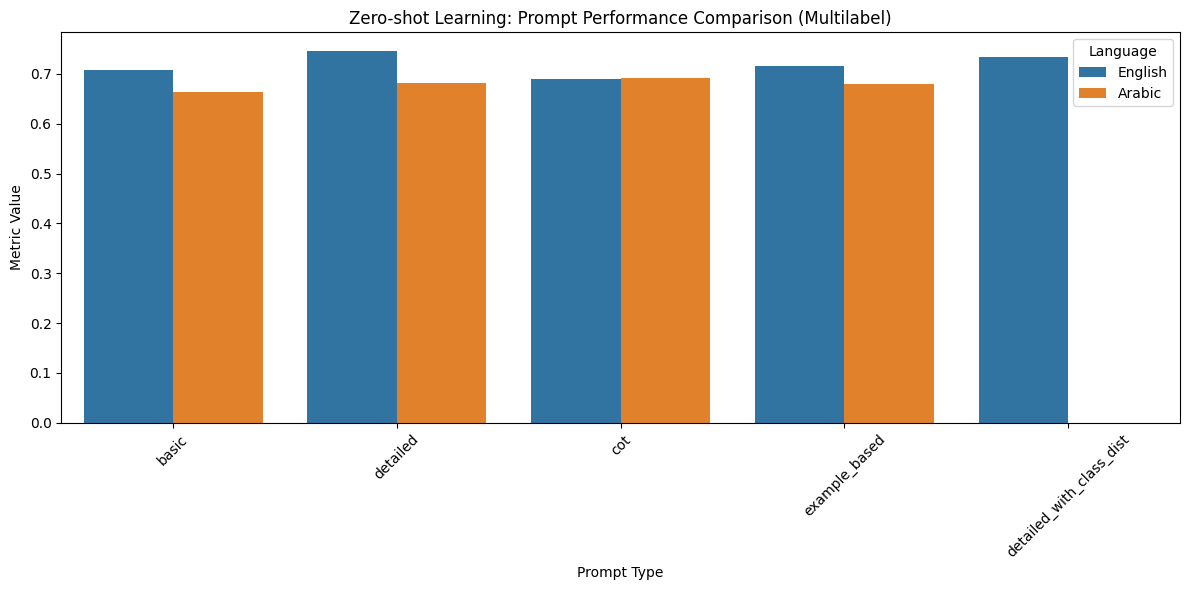

In [ ]:
plot_zero_shot_results(english_results, arabic_results)


In [ ]:
def summarize_and_print_results(english_results, arabic_results, sort_by='f1-score'):
    """
    Summarizes and prints zero-shot learning results in a table, sorted by a specified metric.

    Args:
        english_results: Dictionary with English prompt results.
        arabic_results: Dictionary with Arabic prompt results.
        sort_by: The metric to sort the results by (default: 'f1-score').
    """

    def extract_metrics(report_dict):
        """
        Extracts weighted avg precision, recall, and f1-score from a classification_report dictionary.
        Returns a dictionary of metrics.
        """
        weighted_avg = report_dict.get('weighted avg', {})
        return {
            'precision': weighted_avg.get('precision', 0),
            'recall': weighted_avg.get('recall', 0),
            'f1-score': weighted_avg.get('f1-score', 0),
        }

    # Prepare data for DataFrame
    data = []
    for language, results in [('English', english_results), ('Arabic', arabic_results)]:
        for prompt_name, prompt_results in results.items():
            metrics = extract_metrics(prompt_results["report"])
            row = {'Language': language, 'Prompt': prompt_name, **metrics}
            data.append(row)

    # Create DataFrame
    summary_df = pd.DataFrame(data)

    # Sort by the specified metric
    summary_df = summary_df.sort_values(by=sort_by, ascending=False)

    # Print the table using display() for better formatting in Colab
    display(summary_df)

In [ ]:
summary_df = summarize_and_print_results(english_results, arabic_results)
display(summary_df)

,Language,Prompt,precision,recall,f1-score
1,English,detailed,0.924064,0.594118,0.720716
4,English,detailed_with_class_dist,0.940706,0.564706,0.694745
0,English,basic,0.891750,0.552941,0.679534
3,English,example_based,0.933227,0.547059,0.665936
6,Arabic,detailed,0.850111,0.541176,0.655510
7,Arabic,cot,0.891176,0.529412,0.652990
8,Arabic,example_based,0.852064,0.541176,0.644605
2,English,cot,0.915421,0.517647,0.637365
5,Arabic,basic,0.848582,0.529412,0.616374


None

#### G.2 Few-shot learning

##### G.2.1 Prompt Design

In [ ]:
def generate_few_shot_prompt(train_examples, test_review, language="English", ordering="random"):
    """
    Generate a few-shot prompt with demonstration examples for multi-label classification.

    Args:
        train_examples: List of training examples (review, labels list)
        test_review: Test review text
        language: Language of the prompt
        ordering: Ordering strategy for examples

    Returns:
        prompt: Generated few-shot prompt
    """
    if language == "English":
        prompt = """
You are an expert in classifying app reviews. Given an app review, identify all relevant categories it belongs to.
Each review can belong to multiple categories from the following:
- bug_report: Reports of bugs, errors, crashes, or technical issues in the app
- improvement_request: Suggestions for new features, enhancements, or improvements
- rating: Reviews that primarily express satisfaction or dissatisfaction with the app
- others: Reviews that don't fall into any of the above categories

Here are some examples (multiple labels are comma-separated):

"""
        for i, (review, labels) in enumerate(train_examples):
            label_str = ", ".join(map(str, labels))

            prompt += f"Example {i+1}:\nReview: \"{review}\"\nCategories: {label_str}\n\n"

        prompt += f"Now, classify the following review:\nReview: \"{test_review}\"\nCategories:"

    else:  # Arabic
        prompt = """
أنت خبير في تصنيف مراجعات التطبيقات. بناءً على مراجعة التطبيق، حدد كل الفئات المناسبة لها.
يمكن أن تنتمي المراجعة لأكثر من فئة من الفئات التالية:
- bug_report: تقارير عن أخطاء، مشاكل، انهيارات، أو قضايا تقنية في التطبيق
- improvement_request: اقتراحات لميزات جديدة، تعزيزات، أو تحسينات
- rating: المراجعات التي تعبر بشكل أساسي عن الرضا أو عدم الرضا مع التطبيق
- others: المراجعات التي لا تندرج تحت أي من الفئات المذكورة أعلاه

إليك بعض الأمثلة (الفئات مفصولة بفواصل):

"""
        for i, (review, labels) in enumerate(train_examples):
            label_str = ", ".join(map(str, labels))

            prompt += f"مثال {i+1}:\nمراجعة: \"{review}\"\nالفئات: {label_str}\n\n"

        prompt += f"الآن، صنف المراجعة التالية:\nمراجعة: \"{test_review}\"\nالفئات:"

    return prompt


##### G.2.2 Prompt Engineering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def select_examples_by_similarity(train_df, test_review, n_examples):
    """
    Select examples from training data based on similarity to test review for multilabel classification.

    Args:
        train_df: Training DataFrame
        test_review: Test review text
        n_examples: Number of examples to select

    Returns:
        selected_examples: List of selected examples (review, labels pairs)
    """
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=5000)

    # Fit vectorizer on training data
    train_vectors = vectorizer.fit_transform(train_df['review'])

    # Transform test review
    test_vector = vectorizer.transform([test_review])

    # Calculate similarities
    similarities = cosine_similarity(test_vector, train_vectors).flatten()

    # Select top N examples
    top_indices = similarities.argsort()[-n_examples:][::-1]

    # Select label columns (exclude the 'review' column)
    label_cols = [col for col in train_df.columns if col != 'review']

    # Create list of selected examples (review, corresponding labels)
    selected_examples = [(train_df.iloc[i]['review'], train_df.iloc[i][label_cols].tolist()) for i in top_indices]

    return selected_examples


In [ ]:
def select_examples_by_class(train_df, n_examples):
    """
    Select examples from training data with balanced class representation for multi-label classification.

    Args:
        train_df: Training DataFrame
        n_examples: Number of examples to select

    Returns:
        selected_examples: List of selected examples (review, labels list)
    """
    # Get label columns (excluding 'review')
    label_cols = [col for col in train_df.columns if col != 'review']

    # Calculate examples per label (based on number of unique labels)
    examples_per_label = max(1, n_examples // len(label_cols))

    selected_examples = []

    for label_col in label_cols:
        # Find reviews that have the current label (where the label column is 1)
        label_df = train_df[train_df[label_col] == 1]

        if len(label_df) > 0:
            # Randomly sample a balanced number of reviews
            label_samples = label_df.sample(min(examples_per_label, len(label_df)))

            # Add selected samples to the output
            for _, row in label_samples.iterrows():
                selected_examples.append((row['review'], row[label_cols].tolist()))

    # If we need more examples, sample randomly from the rest
    if len(selected_examples) < n_examples:
        remaining = n_examples - len(selected_examples)
        remaining_df = train_df[~train_df.index.isin([idx for _, idx in selected_examples])]
        if len(remaining_df) > 0:
            additional_samples = remaining_df.sample(min(remaining, len(remaining_df)))
            for _, row in additional_samples.iterrows():
                selected_examples.append((row['review'], row[label_cols].tolist()))

    return selected_examples


In [ ]:
import random

def order_examples(examples, ordering="random"):
    """
    Order examples according to specified strategy for multi-label classification.

    Args:
        examples: List of examples (review, labels list)
        ordering: Ordering strategy

    Returns:
        ordered_examples: Ordered list of examples
    """
    if ordering == "random":
        random.shuffle(examples)
        return examples
    elif ordering == "by_label":
        # Sort by the number of labels (more labels means it comes later)
        return sorted(examples, key=lambda x: len(x[1]))
    elif ordering == "by_length":
        # Sort by the length of the review text
        return sorted(examples, key=lambda x: len(x[0]))
    else:
        return examples


##### G.2.3 Prompt Evaluation

In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import time
import numpy as np

def evaluate_few_shot(train_df, val_df, possible_labels, n_shots_list, language="English", selection_method="random", ordering="random", n_samples=100):
    print(f"\n=== Few-shot Learning ({language}, {selection_method}, {ordering}) ===\n")
    label_cols = [col for col in train_df.columns if col != 'review']

    if n_samples < len(val_df):
        val_sample = val_df.sample(n=n_samples, random_state=42)
    else:
        val_sample = val_df

    results = {}
    mlb = MultiLabelBinarizer()
    mlb.fit([possible_labels])

    for n_shots in n_shots_list:
        print(f"\nEvaluating {n_shots}-shot learning")
        true_labels = []
        predictions = []

        for idx, row in tqdm(val_sample.iterrows(), total=len(val_sample), desc=f"{n_shots}-shot"):
            test_review = row['review']
            true_label = [col for col in row.index if row[col] == 1]
            true_labels.append(true_label)

            if selection_method == "similarity":
                examples = select_examples_by_similarity(train_df, test_review, n_shots)
            elif selection_method == "by_class":
                examples = select_examples_by_class(train_df, n_shots)
            else:
                examples = list(zip(train_df.sample(n=n_shots)['review'], train_df.sample(n=n_shots)[label_cols]))

            examples = order_examples(examples, ordering)
            prompt = generate_few_shot_prompt(examples, test_review, language, ordering)

            messages = [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ]

            response = call_llm_api(messages)
            predicted_label = parse_response(response, possible_labels)

            predicted_label_binary = mlb.transform([predicted_label])[0]
            predictions.append(predicted_label_binary)

            time.sleep(0.5)

        true_labels_binary = np.array([mlb.transform([label])[0] for label in true_labels])
        predictions_binary = np.array(predictions)

        precision_weighted = precision_score(true_labels_binary, predictions_binary, average="weighted", zero_division=0)
        recall_weighted = recall_score(true_labels_binary, predictions_binary, average="weighted", zero_division=0)
        f1_weighted = f1_score(true_labels_binary, predictions_binary, average="weighted", zero_division=0)

        # Generate report
        report = classification_report(true_labels_binary, predictions_binary, target_names=possible_labels, zero_division=0, output_dict=True)

        print(f"\n{n_shots}-shot learning results:")
        print(f"precision_weighted: {precision_weighted:.4f}")
        print(f"recall_weighted: {recall_weighted:.4f}")
        print(f"F1 Weighted: {f1_weighted:.4f}")

        results[n_shots] = {
            "precision_weighted": precision_weighted,
            "recall_weighted": recall_weighted,
            "f1_weighted": f1_weighted,
            "predictions": predictions,
            "true_labels": true_labels,
            "report": report
        }

    return results


In [ ]:
import matplotlib.pyplot as plt

def plot_few_shot_results(results_dict, title):
    """
    Plot few-shot learning results (F1 scores).

    Args:
        results_dict: Dictionary with results
        title: Plot title
    """
    n_shots = list(results_dict.keys())
    f1_weighted = [results_dict[k]["f1_weighted"] for k in n_shots]

    plt.figure(figsize=(10, 6))

    # Plot the F1 scores for each type
    plt.plot(n_shots, f1_weighted, marker='^', linestyle='-.', linewidth=2, label='F1 Weighted')

    plt.title(title)
    plt.xlabel("Number of Demonstration Examples")
    plt.ylabel("F1 Score")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(n_shots)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()


In [ ]:
def few_shot_learning(train_df, val_df, possible_labels, n_samples=100):
    """
    Perform few-shot learning experiments with different configurations.

    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        possible_labels: List of possible class labels
        n_samples: Number of samples to evaluate on

    Returns:
        results: Dictionary with evaluation results
    """
    print("\n=== Few-shot Learning Experiments ===\n")

    # Define number of shots to try
    n_shots_list = [1, 2, 4, 8, 16]

    # Evaluate basic few-shot learning (English, random selection, random ordering)
    english_random_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "random", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_random_results, "Few-shot Learning: English, Random Selection")

    # Evaluate basic few-shot learning (Arabic, random selection, random ordering)
    arabic_random_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "Arabic", "random", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(arabic_random_results, "Few-shot Learning: Arabic, Random Selection")

    # BONUS: Evaluate few-shot learning with similarity-based selection
    english_similarity_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "similarity", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_similarity_results, "Few-shot Learning: English, Similarity Selection")

    # BONUS: Evaluate few-shot learning with class-based selection
    english_class_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "by_class", "random", n_samples
    )

    # Plot results
    plot_few_shot_results(english_class_results, "Few-shot Learning: English, Class-based Selection")

    # BONUS: Evaluate few-shot learning with different ordering strategies
    english_ordered_results = evaluate_few_shot(
        train_df, val_df, possible_labels, n_shots_list,
        "English", "random", "by_label", n_samples
    )

    # Plot results
    plot_few_shot_results(english_ordered_results, "Few-shot Learning: English, Ordered by Label")

    # Determine best configuration
    all_results = {
        "English, Random Selection": english_random_results,
        "Arabic, Random Selection": arabic_random_results,
        "English, Similarity Selection": english_similarity_results,
        "English, Class-based Selection": english_class_results,
        "English, Ordered by Label": english_ordered_results
    }

    best_configuration = None
    best_shots = None
    best_f1_weighted = 0

    for config_name, config_results in all_results.items():
        for n_shots, result in config_results.items():
            # Safely check if the "report" key exists before accessing
            if "report" in result:
                f1_weighted = result["report"].get("weighted avg", {}).get("f1-score", 0)  # Extract weighted F1
                if f1_weighted > best_f1_weighted:
                    best_f1_weighted = f1_weighted
                    best_configuration = config_name
                    best_shots = n_shots
            else:
                print(f"Warning: 'report' key is missing for {config_name} with {n_shots} shots")

    print(f"\nBest few-shot configuration: {best_configuration} with {best_shots} shots")
    print(f"Best weighted F1-score: {best_f1_weighted:.4f}")  # Print weighted F1
    return {
        "english_random": english_random_results,
        "arabic_random": arabic_random_results,
        "english_similarity": english_similarity_results,
        "english_class": english_class_results,
        "english_ordered": english_ordered_results,
        "best_configuration": best_configuration,
        "best_shots": best_shots,
        "best_f1_weighted": best_f1_weighted  # Store weighted F1
    }



=== Few-shot Learning Experiments ===


=== Few-shot Learning (English, random, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]



1-shot learning results:
precision_weighted: 0.8216
recall_weighted: 0.6294
F1 Weighted: 0.7051

Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]



2-shot learning results:
precision_weighted: 0.8283
recall_weighted: 0.6000
F1 Weighted: 0.6866

Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]



4-shot learning results:
precision_weighted: 0.8419
recall_weighted: 0.5294
F1 Weighted: 0.6302

Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]



8-shot learning results:
precision_weighted: 0.8189
recall_weighted: 0.5000
F1 Weighted: 0.5882

Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]



16-shot learning results:
precision_weighted: 0.8142
recall_weighted: 0.5529
F1 Weighted: 0.6395


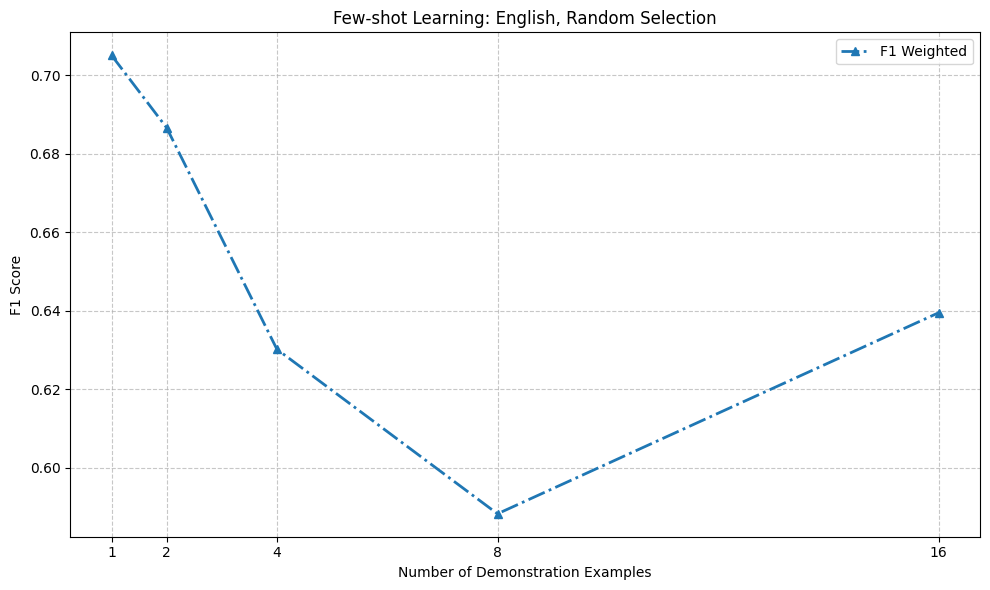


=== Few-shot Learning (Arabic, random, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]



1-shot learning results:
precision_weighted: 0.3529
recall_weighted: 0.1882
F1 Weighted: 0.1168

Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]



2-shot learning results:
precision_weighted: 0.3620
recall_weighted: 0.2353
F1 Weighted: 0.2012

Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]



4-shot learning results:
precision_weighted: 0.7452
recall_weighted: 0.3118
F1 Weighted: 0.3327

Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [01:41<00:00,  1.02s/it]



8-shot learning results:
precision_weighted: 0.8002
recall_weighted: 0.3118
F1 Weighted: 0.3414

Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]



16-shot learning results:
precision_weighted: 0.8027
recall_weighted: 0.2882
F1 Weighted: 0.2905


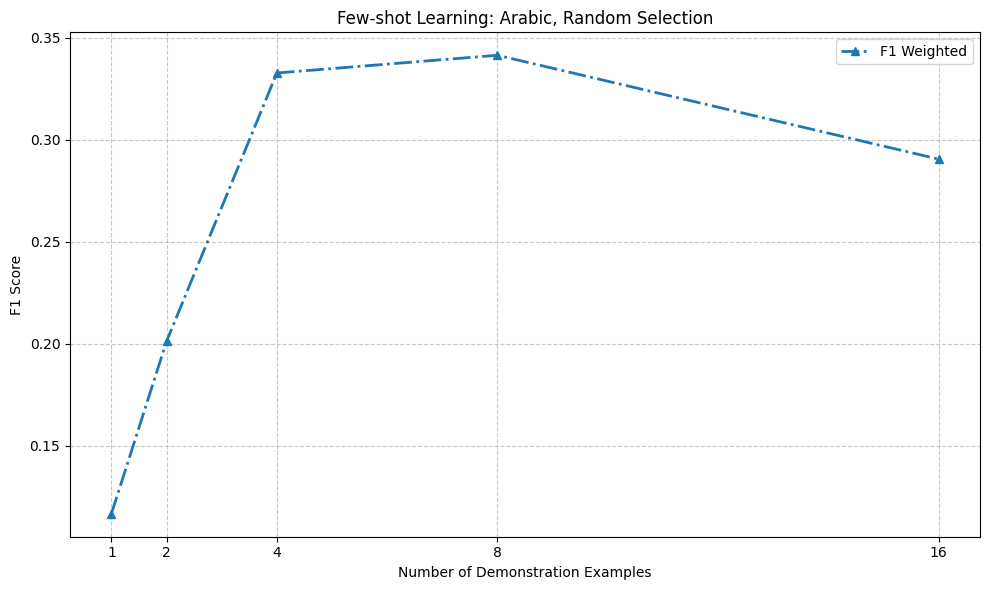


=== Few-shot Learning (English, similarity, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]



1-shot learning results:
precision_weighted: 0.6011
recall_weighted: 0.6000
F1 Weighted: 0.5560

Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]



2-shot learning results:
precision_weighted: 0.6005
recall_weighted: 0.6706
F1 Weighted: 0.5759

Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [03:13<00:00,  1.93s/it]



4-shot learning results:
precision_weighted: 0.6020
recall_weighted: 0.6647
F1 Weighted: 0.5790

Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]



8-shot learning results:
precision_weighted: 0.5560
recall_weighted: 0.7176
F1 Weighted: 0.5881

Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]



16-shot learning results:
precision_weighted: 0.5664
recall_weighted: 0.7294
F1 Weighted: 0.5984


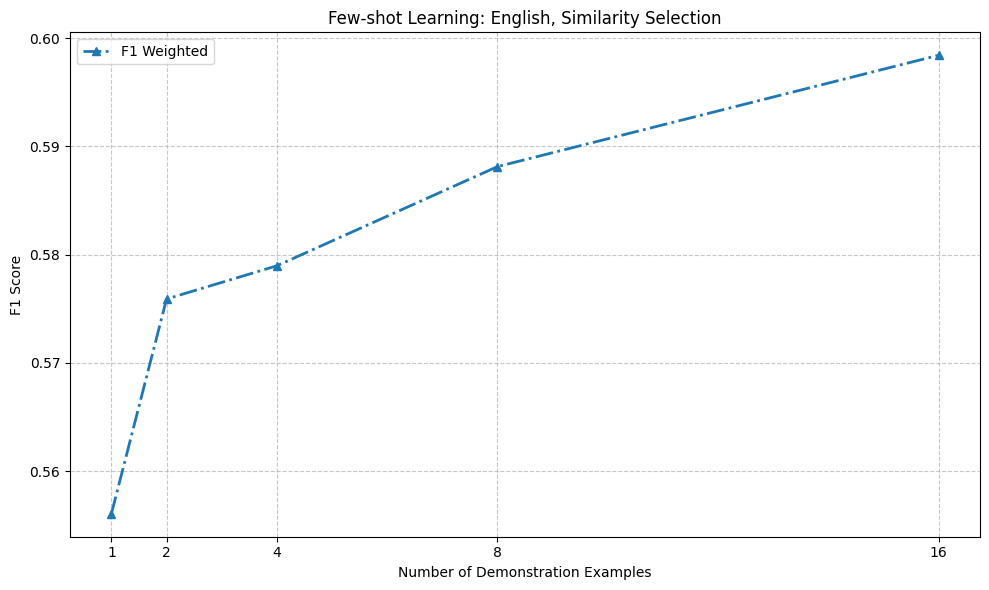


=== Few-shot Learning (English, by_class, random) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]



1-shot learning results:
precision_weighted: 0.5894
recall_weighted: 0.6765
F1 Weighted: 0.5747

Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]



2-shot learning results:
precision_weighted: 0.6022
recall_weighted: 0.6647
F1 Weighted: 0.5724

Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]



4-shot learning results:
precision_weighted: 0.6023
recall_weighted: 0.7294
F1 Weighted: 0.6135

Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]



8-shot learning results:
precision_weighted: 0.6020
recall_weighted: 0.7059
F1 Weighted: 0.6033

Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]



16-shot learning results:
precision_weighted: 0.6002
recall_weighted: 0.7000
F1 Weighted: 0.6016


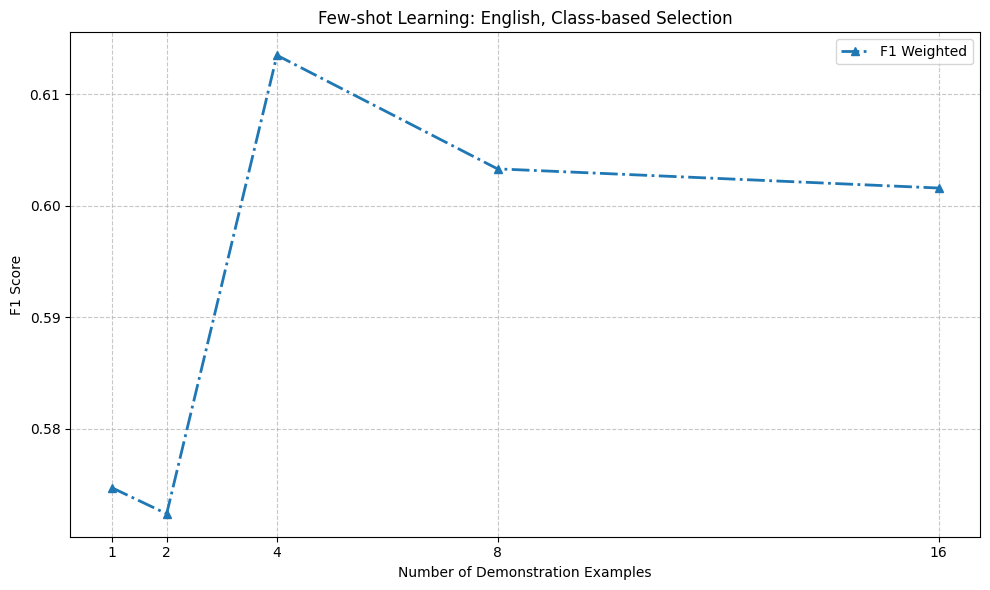


=== Few-shot Learning (English, random, by_label) ===


Evaluating 1-shot learning


1-shot: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]



1-shot learning results:
precision_weighted: 0.7890
recall_weighted: 0.6353
F1 Weighted: 0.6935

Evaluating 2-shot learning


2-shot: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s]



2-shot learning results:
precision_weighted: 0.7747
recall_weighted: 0.6176
F1 Weighted: 0.6779

Evaluating 4-shot learning


4-shot: 100%|██████████| 100/100 [03:02<00:00,  1.83s/it]



4-shot learning results:
precision_weighted: 0.8214
recall_weighted: 0.5176
F1 Weighted: 0.6093

Evaluating 8-shot learning


8-shot: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]



8-shot learning results:
precision_weighted: 0.8149
recall_weighted: 0.4765
F1 Weighted: 0.5753

Evaluating 16-shot learning


16-shot: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]



16-shot learning results:
precision_weighted: 0.7834
recall_weighted: 0.5176
F1 Weighted: 0.6071


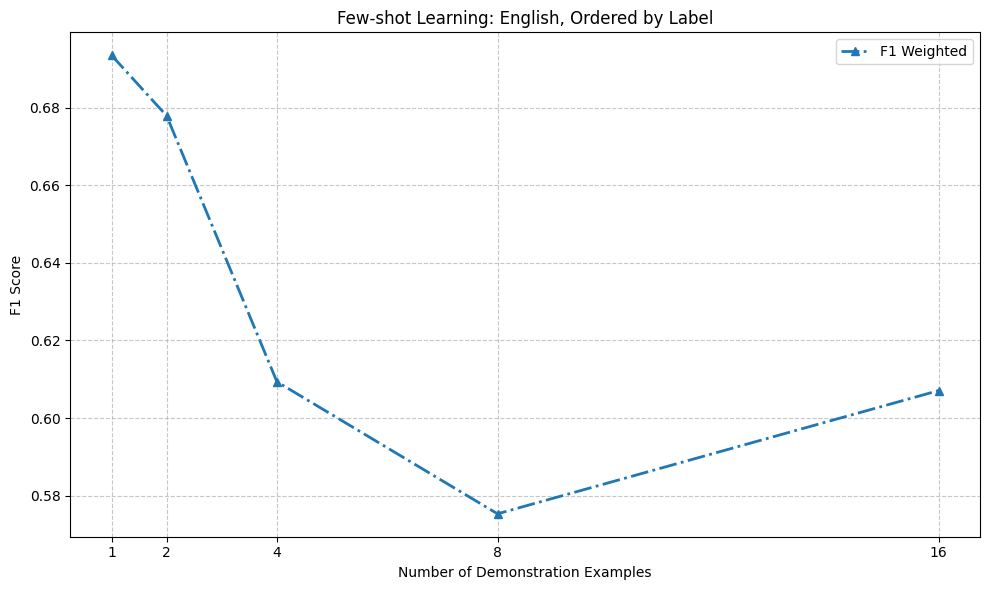


Best few-shot configuration: English, Random Selection with 1 shots
Best weighted F1-score: 0.7051


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import time
import pandas as pd
import re
from sklearn.metrics import precision_score, recall_score, f1_score

# Few-shot learning experiments
few_shot_results = few_shot_learning(train_df, val_df, possible_labels, n_samples=100)

In [ ]:
import matplotlib.pyplot as plt

def plot_all_few_shot_results(few_shot_results, metric="f1_weighted"):
    """
    Plot F1 score vs. number of shots for all few-shot learning configurations.

    Args:
        few_shot_results: Dictionary containing results for multiple configurations.
                          Expected format: {config_name: {n_shots: result_dict}}
        metric: F1 score metric to plot. One of: 'f1_micro', 'f1_macro', 'f1_weighted'.
    """
    result_keys = ["english_random", "arabic_random", "english_similarity",
                   "english_class", "english_ordered"]

    filtered_results = {k: v for k, v in few_shot_results.items() if k in result_keys}

    plt.figure(figsize=(10, 6))
    markers = ['o', 's', 'D', '^', 'v', '*', 'x']

    for i, (label, config) in enumerate(filtered_results.items()):
        x = sorted(config.keys())
        y = [config[shots][metric] for shots in x]
        plt.plot(x, y, marker=markers[i % len(markers)], label=label)

    plt.title(f"Few-shot Learning: {metric.replace('_', ' ').title()} vs. Number of Shots")
    plt.xlabel("Number of Shots")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

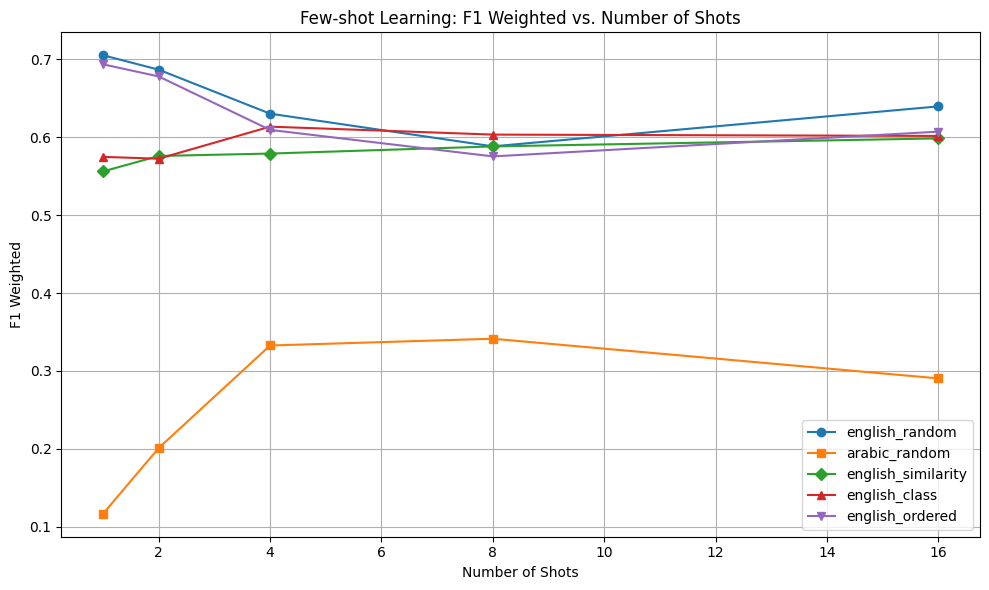

In [ ]:
plot_all_few_shot_results(few_shot_results)

In [ ]:
def format_few_shot_results_table(few_shot_results):
    """
    Format few-shot learning results into a DataFrame similar to the zero-shot results table.
    Uses weighted F1 score to determine the best number of shots.
    Handles None values for metrics.
    Focuses on weighted, macro, and micro F1 scores.
    """
    rows = []

    config_mappings = {
        "english_random": ("English", "random"),
        "arabic_random": ("Arabic", "random"),
        "english_similarity": ("English", "similarity"),
        "english_class": ("English", "by_class"),
        "english_ordered": ("English", "by_label")
    }


    result_keys = config_mappings.keys()

    for key, results in few_shot_results.items():
        if key not in result_keys:
            continue

        language, strategy = config_mappings.get(key, ("Unknown", "Unknown"))

        # Find best number of shots based on weighted F1 score
        best_shot = max(results.items(), key=lambda x: x[1].get("f1_weighted", 0))[0]
        best_result = results[best_shot]

        row = {
            "Prompt Language": language,
            "Prompt Strategy": strategy,
            "Shots": best_shot,
            "Weighted Precision": round(best_result.get("precision_weighted", float('nan')), 4),
            "Weighted Recall": round(best_result.get("recall_weighted", float('nan')), 4),
            "Weighted F1-Score": round(best_result.get("f1_weighted", float('nan')), 4)
        }
        rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
table_df = format_few_shot_results_table(few_shot_results)
display(table_df)


,Prompt Language,Prompt Strategy,Shots,Weighted Precision,Weighted Recall,Weighted F1-Score
0,English,random,1,0.8216,0.6294,0.7051
1,Arabic,random,8,0.8002,0.3118,0.3414
2,English,similarity,16,0.5664,0.7294,0.5984
3,English,by_class,4,0.6023,0.7294,0.6135
4,English,by_label,1,0.7890,0.6353,0.6935


#### G.3 Zero-shot VS Few-shot

In [ ]:
# Compare best zero-shot and few-shot results
print("\n=== Comparison of Best Zero-shot and Few-shot Results ===\n")
print(f"Best zero-shot: English-detailed with F1-Score of 0.720716")
print(f"Best few-shot: English-random with 1 shot and F1-Score of 0.7051")




=== Comparison of Best Zero-shot and Few-shot Results ===

Best zero-shot: English-detailed with F1-Score of 0.720716
Best few-shot: English-random with 1 shot and F1-Score of 0.7051
